In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import Model, layers
from keras.layers import Dense #Conv1D, LSTM, MaxPool1D
from tcn import TCN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Only display tensorflow errors
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2025-03-24 03:03:02.948358: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742778182.958844 2634681 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742778182.961966 2634681 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742778182.970964 2634681 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742778182.970972 2634681 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742778182.970973 2634681 computation_placer.cc:177] computation placer alr

In [2]:
df = pd.read_csv('data/comp-merged.csv')
df = df[['value_acc', 'value_met']]
scaler = MinMaxScaler()
df['value_met'] = scaler.fit_transform(df['value_met'].values.reshape(-1, 1))
df['value_acc'] = scaler.transform(df['value_acc'].values.reshape(-1, 1))

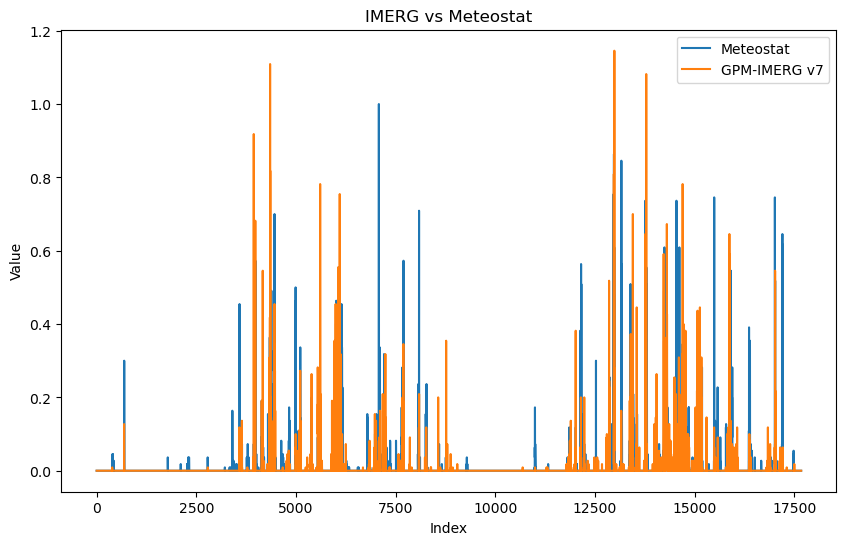

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(df['value_met'], label='Meteostat')
plt.plot(df['value_acc'], label='GPM-IMERG v7')
plt.title('IMERG vs Meteostat')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [4]:
batch_size = 256
epochs = 1000
window_size = 32

In [5]:
def windowed_dataset(data, window_size, batch_size, shuffle=True):
    """
    Create a windowed dataset from the input data.

    Parameters:
    data (np.array): The input data array.
    window_size (int): The size of each window.
    batch_size (int): The size of each batch.

    Returns:
    tf.data.Dataset: The windowed dataset.
    """
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.map(lambda window: (tf.expand_dims(window[:, 0], axis=-1), tf.expand_dims(window[:, 1], axis=-1)))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
def windowed_dataset_single(data, window_size, batch_size):
    """
    Create a windowed dataset from the input data.

    Parameters:
    data (np.array): The input data array.
    window_size (int): The size of each window.
    batch_size (int): The size of each batch.

    Returns:
    tf.data.Dataset: The windowed dataset.
    """
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=window_size, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.map(lambda window: tf.expand_dims(window, axis=-1))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
# Split the dataframe into train and test sets
train, test = train_test_split(df, test_size=0.1, shuffle=False)

train_set = windowed_dataset(train, window_size, batch_size, shuffle=True)
test_set = windowed_dataset(test, window_size, batch_size, shuffle=False)

I0000 00:00:1742778203.080573 2634681 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21866 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:08:00.0, compute capability: 8.6


2025-03-24 03:03:25.013310: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/tmp/ipykernel_2634681/4153096080.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


(256, 32, 1)
(564672,)
(17677,)


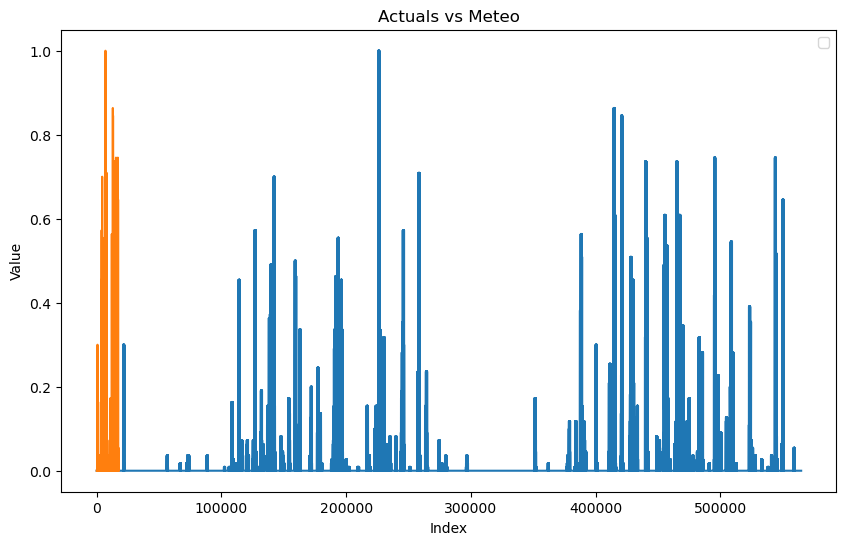

In [8]:
data = windowed_dataset(df, window_size, batch_size, shuffle=False)
actuals = [y for x, y in data]
print(actuals[0].shape)
actuals = np.concatenate(actuals, axis=0).flatten()

print(actuals.shape)
print(df['value_met'].shape)

plt.figure(figsize=(10, 6))
plt.plot(actuals)
plt.plot(df['value_met'])
plt.title('Actuals vs Meteo')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [9]:
class RootMeanSqauredError(keras.metrics.MeanSquaredError):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(y_true, y_pred, sample_weight)

    def result(self):
        return tf.sqrt(super().result())

In [10]:
def build_model():
    """
    Build a CONV-LSTM model for error correction.
    
    Returns:
    keras.Model: The compiled model
    """
    # Input layer
    inputs = layers.Input(shape=(window_size, 1))
    
    # Encoder: progressively extract features
    encoded = TCN(nb_filters=256, return_sequences=True, dilations=[1, 2, 4, 8])(inputs)
    # Optional bottleneck layer to compress the representation further
    bottleneck = layers.Dense(64, activation=None)(encoded)
    
    # Decoder: reconstruct the sequence from the bottleneck feature map
    decoded = TCN(nb_filters=256, return_sequences=True, dilations=[1, 2, 4, 8])(bottleneck)
    outputs = Dense(1)(decoded)
    
    lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=2000,
        decay_rate=0.9
    )

    # Create and compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.AdamW(lr_scheduler), loss='mse', metrics=['mae', RootMeanSqauredError(name='rmse')])
    
    return model

In [11]:
model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn (TCN)                       │ (None, 32, 256)        │       920,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn_1 (TCN)                     │ (None, 32, 256)        │       968,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32, 1)          │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,906,241 (7.27 MB)

 Trainable params: 1,906,241 (7.27 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
  train_set,
  epochs=epochs,
  validation_data=test_set,
  verbose=1,
#   callbacks=[keras.callbacks.EarlyStopping(patience=10, monitor='val_rmse', min_delta=1e-6)]
)

Epoch 1/1000


I0000 00:00:1742778221.547768 2637722 service.cc:152] XLA service 0x7fc1140200b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742778221.547782 2637722 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-03-24 03:03:41.646516: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742778222.209940 2637722 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-24 03:03:42.784836: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 64 bytes spill stores, 64 bytes spill loads

2025-03-24 03:03:42.870039: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 80 bytes

     16/Unknown 8s 11ms/step - loss: 0.1068 - mae: 0.0915 - rmse: 0.3139

I0000 00:00:1742778226.164873 2637722 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     61/Unknown 8s 11ms/step - loss: 0.0839 - mae: 0.0733 - rmse: 0.2825

2025-03-24 03:03:48.002333: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 80 bytes spill stores, 80 bytes spill loads

2025-03-24 03:03:48.565443: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4041', 56 bytes spill stores, 56 bytes spill loads

2025-03-24 03:03:48.737511: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3', 432 bytes spill stores, 336 bytes spill loads

2025-03-24 03:03:48.761102: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3', 568 bytes spill stores, 440 bytes spill loads

2025-03-24 03:03:48.773892: I external/local_xl

     63/Unknown 12s 72ms/step - loss: 0.0826 - mae: 0.0726 - rmse: 0.2802

2025-03-24 03:03:50.630317: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/edargham/anaconda3/envs/thesis/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-03-24 03:03:52.600385: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 80 bytes spill stores, 80 bytes spill loads



63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - loss: 0.0820 - mae: 0.0722 - rmse: 0.2791 - val_loss: 0.0027 - val_mae: 0.0165 - val_rmse: 0.0516
Epoch 2/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3669e-04 - mae: 0.0076 - rmse: 0.0117

2025-03-24 03:03:53.296901: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-24 03:03:53.296915: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0068 - mae: 0.0232 - rmse: 0.0762 - val_loss: 0.0024 - val_mae: 0.0142 - val_rmse: 0.0488
Epoch 3/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.9530e-05 - mae: 0.0051 - rmse: 0.0094

2025-03-24 03:03:54.082698: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-24 03:03:54.082715: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0012 - mae: 0.0099 - rmse: 0.0325 - val_loss: 0.0023 - val_mae: 0.0126 - val_rmse: 0.0483
Epoch 4/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.6517e-05 - mae: 0.0055 - rmse: 0.0098

2025-03-24 03:03:54.868430: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:03:54.868446: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0012 - mae: 0.0110 - rmse: 0.0322 - val_loss: 0.0023 - val_mae: 0.0120 - val_rmse: 0.0481
Epoch 5/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1455e-04 - mae: 0.0069 - rmse: 0.0107

2025-03-24 03:03:55.646626: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-24 03:03:55.646644: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0014 - mae: 0.0132 - rmse: 0.0350 - val_loss: 0.0023 - val_mae: 0.0116 - val_rmse: 0.0480
Epoch 6/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0014 - mae: 0.0130 - rmse: 0.0354 - val_loss: 0.0023 - val_mae: 0.0118 - val_rmse: 0.0482
Epoch 7/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.1534e-05 - mae: 0.0045 - rmse: 0.0090

2025-03-24 03:03:57.219643: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.9215e-04 - mae: 0.0091 - rmse: 0.0295 - val_loss: 0.0023 - val_mae: 0.0110 - val_rmse: 0.0483
Epoch 8/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.3320e-05 - mae: 0.0036 - rmse: 0.0079

2025-03-24 03:03:58.002109: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:03:58.002125: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.3890e-04 - mae: 0.0087 - rmse: 0.0285 - val_loss: 0.0023 - val_mae: 0.0109 - val_rmse: 0.0484
Epoch 9/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.2382e-05 - mae: 0.0050 - rmse: 0.0091

2025-03-24 03:03:58.782523: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-24 03:03:58.782541: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:03:58.782547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.5238e-04 - mae: 0.0098 - rmse: 0.0289 - val_loss: 0.0023 - val_mae: 0.0120 - val_rmse: 0.0481
Epoch 10/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.4903e-05 - mae: 0.0060 - rmse: 0.0092

2025-03-24 03:03:59.570847: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.5749e-04 - mae: 0.0102 - rmse: 0.0290 - val_loss: 0.0023 - val_mae: 0.0102 - val_rmse: 0.0484
Epoch 11/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.7496e-05 - mae: 0.0051 - rmse: 0.0093

2025-03-24 03:04:00.353109: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:00.353126: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.0161e-04 - mae: 0.0097 - rmse: 0.0282 - val_loss: 0.0023 - val_mae: 0.0109 - val_rmse: 0.0481
Epoch 12/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2311e-04 - mae: 0.0076 - rmse: 0.0111

2025-03-24 03:04:01.141114: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:01.141133: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0010 - mae: 0.0115 - rmse: 0.0301 - val_loss: 0.0023 - val_mae: 0.0104 - val_rmse: 0.0481
Epoch 13/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.3480e-05 - mae: 0.0036 - rmse: 0.0079

2025-03-24 03:04:01.928513: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.9617e-04 - mae: 0.0087 - rmse: 0.0279 - val_loss: 0.0023 - val_mae: 0.0111 - val_rmse: 0.0480
Epoch 14/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.8921e-05 - mae: 0.0048 - rmse: 0.0088

2025-03-24 03:04:02.709233: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.9864e-04 - mae: 0.0092 - rmse: 0.0281 - val_loss: 0.0023 - val_mae: 0.0099 - val_rmse: 0.0481
Epoch 15/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.9725e-05 - mae: 0.0039 - rmse: 0.0083

2025-03-24 03:04:03.492487: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.3138e-04 - mae: 0.0084 - rmse: 0.0269 - val_loss: 0.0024 - val_mae: 0.0137 - val_rmse: 0.0485
Epoch 16/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0015 - mae: 0.0131 - rmse: 0.0366 - val_loss: 0.0023 - val_mae: 0.0100 - val_rmse: 0.0481
Epoch 17/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.8289e-05 - mae: 0.0021 - rmse: 0.0082

2025-03-24 03:04:05.066202: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-24 03:04:05.066223: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:05.066233: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0013 - mae: 0.0092 - rmse: 0.0334 - val_loss: 0.0023 - val_mae: 0.0126 - val_rmse: 0.0478
Epoch 18/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.4407e-05 - mae: 0.0044 - rmse: 0.0086

2025-03-24 03:04:05.851962: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:05.851979: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0010 - mae: 0.0095 - rmse: 0.0302 - val_loss: 0.0023 - val_mae: 0.0113 - val_rmse: 0.0480
Epoch 19/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.7203e-05 - mae: 0.0044 - rmse: 0.0087

2025-03-24 03:04:06.631320: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:06.631340: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.1603e-04 - mae: 0.0086 - rmse: 0.0283 - val_loss: 0.0023 - val_mae: 0.0151 - val_rmse: 0.0478
Epoch 20/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2169e-04 - mae: 0.0081 - rmse: 0.0110

2025-03-24 03:04:07.421339: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0010 - mae: 0.0111 - rmse: 0.0305 - val_loss: 0.0023 - val_mae: 0.0110 - val_rmse: 0.0480
Epoch 21/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.3361e-05 - mae: 0.0043 - rmse: 0.0085

2025-03-24 03:04:08.205645: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.7576e-04 - mae: 0.0085 - rmse: 0.0276 - val_loss: 0.0023 - val_mae: 0.0141 - val_rmse: 0.0482
Epoch 22/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.6131e-05 - mae: 0.0065 - rmse: 0.0098

2025-03-24 03:04:09.011771: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.9020e-04 - mae: 0.0106 - rmse: 0.0296 - val_loss: 0.0023 - val_mae: 0.0110 - val_rmse: 0.0480
Epoch 23/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.7886e-05 - mae: 0.0053 - rmse: 0.0088

2025-03-24 03:04:09.797551: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:09.797569: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.8193e-04 - mae: 0.0095 - rmse: 0.0279 - val_loss: 0.0023 - val_mae: 0.0102 - val_rmse: 0.0483
Epoch 24/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.0819e-05 - mae: 0.0041 - rmse: 0.0084

2025-03-24 03:04:10.585114: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.4182e-04 - mae: 0.0084 - rmse: 0.0271 - val_loss: 0.0023 - val_mae: 0.0158 - val_rmse: 0.0482
Epoch 25/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.3714e-05 - mae: 0.0070 - rmse: 0.0096

2025-03-24 03:04:11.369605: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:11.369624: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.3751e-04 - mae: 0.0096 - rmse: 0.0273 - val_loss: 0.0023 - val_mae: 0.0128 - val_rmse: 0.0480
Epoch 26/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.1805e-05 - mae: 0.0053 - rmse: 0.0090

2025-03-24 03:04:12.154112: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:12.154129: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.9286e-04 - mae: 0.0086 - rmse: 0.0264 - val_loss: 0.0023 - val_mae: 0.0137 - val_rmse: 0.0481
Epoch 27/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.0320e-05 - mae: 0.0070 - rmse: 0.0095

2025-03-24 03:04:12.947504: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:12.947523: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.4640e-04 - mae: 0.0102 - rmse: 0.0274 - val_loss: 0.0023 - val_mae: 0.0119 - val_rmse: 0.0481
Epoch 28/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.1761e-05 - mae: 0.0056 - rmse: 0.0084

2025-03-24 03:04:13.745290: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:13.745306: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.4870e-04 - mae: 0.0087 - rmse: 0.0256 - val_loss: 0.0023 - val_mae: 0.0152 - val_rmse: 0.0481
Epoch 29/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0605e-04 - mae: 0.0077 - rmse: 0.0102

2025-03-24 03:04:14.540505: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:14.540524: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.8852e-04 - mae: 0.0098 - rmse: 0.0266 - val_loss: 0.0024 - val_mae: 0.0164 - val_rmse: 0.0485
Epoch 30/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2459e-04 - mae: 0.0090 - rmse: 0.0111

2025-03-24 03:04:15.331885: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:15.331903: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.3151e-04 - mae: 0.0106 - rmse: 0.0274 - val_loss: 0.0023 - val_mae: 0.0145 - val_rmse: 0.0482
Epoch 31/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.7650e-05 - mae: 0.0055 - rmse: 0.0087

2025-03-24 03:04:16.123627: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.9567e-04 - mae: 0.0082 - rmse: 0.0248 - val_loss: 0.0024 - val_mae: 0.0195 - val_rmse: 0.0488
Epoch 32/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9078e-04 - mae: 0.0117 - rmse: 0.0137

2025-03-24 03:04:16.918466: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.7720e-04 - mae: 0.0110 - rmse: 0.0268 - val_loss: 0.0024 - val_mae: 0.0178 - val_rmse: 0.0486
Epoch 33/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0990e-04 - mae: 0.0079 - rmse: 0.0104

2025-03-24 03:04:17.708943: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-24 03:04:17.708961: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.7186e-04 - mae: 0.0100 - rmse: 0.0263 - val_loss: 0.0024 - val_mae: 0.0144 - val_rmse: 0.0486
Epoch 34/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.5573e-05 - mae: 0.0069 - rmse: 0.0092

2025-03-24 03:04:18.492341: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:18.492359: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.5291e-04 - mae: 0.0088 - rmse: 0.0241 - val_loss: 0.0025 - val_mae: 0.0209 - val_rmse: 0.0496
Epoch 35/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8093e-04 - mae: 0.0113 - rmse: 0.0134

2025-03-24 03:04:19.280792: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.7881e-04 - mae: 0.0126 - rmse: 0.0300 - val_loss: 0.0024 - val_mae: 0.0194 - val_rmse: 0.0492
Epoch 36/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.6728e-04 - mae: 0.0101 - rmse: 0.0262 - val_loss: 0.0024 - val_mae: 0.0167 - val_rmse: 0.0486
Epoch 37/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.2515e-05 - mae: 0.0073 - rmse: 0.0095

2025-03-24 03:04:20.860195: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.4966e-04 - mae: 0.0086 - rmse: 0.0241 - val_loss: 0.0024 - val_mae: 0.0193 - val_rmse: 0.0493
Epoch 38/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.8679e-04 - mae: 0.0103 - rmse: 0.0251 - val_loss: 0.0024 - val_mae: 0.0160 - val_rmse: 0.0492
Epoch 39/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.4867e-05 - mae: 0.0068 - rmse: 0.0086

2025-03-24 03:04:22.434956: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.9782e-04 - mae: 0.0082 - rmse: 0.0231 - val_loss: 0.0024 - val_mae: 0.0173 - val_rmse: 0.0492
Epoch 40/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.2689e-04 - mae: 0.0091 - rmse: 0.0238 - val_loss: 0.0024 - val_mae: 0.0166 - val_rmse: 0.0491
Epoch 41/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.8965e-05 - mae: 0.0071 - rmse: 0.0088

2025-03-24 03:04:24.011679: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.6495e-04 - mae: 0.0081 - rmse: 0.0224 - val_loss: 0.0024 - val_mae: 0.0147 - val_rmse: 0.0493
Epoch 42/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.6588e-04 - mae: 0.0080 - rmse: 0.0223 - val_loss: 0.0024 - val_mae: 0.0176 - val_rmse: 0.0493
Epoch 43/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.6230e-05 - mae: 0.0069 - rmse: 0.0086

2025-03-24 03:04:25.595053: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.2841e-04 - mae: 0.0090 - rmse: 0.0237 - val_loss: 0.0024 - val_mae: 0.0162 - val_rmse: 0.0494
Epoch 44/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.4992e-05 - mae: 0.0072 - rmse: 0.0086

2025-03-24 03:04:26.383765: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.6432e-04 - mae: 0.0083 - rmse: 0.0225 - val_loss: 0.0024 - val_mae: 0.0160 - val_rmse: 0.0490
Epoch 45/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.1580e-05 - mae: 0.0063 - rmse: 0.0078

2025-03-24 03:04:27.167688: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:27.167704: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.2831e-04 - mae: 0.0081 - rmse: 0.0236 - val_loss: 0.0024 - val_mae: 0.0149 - val_rmse: 0.0489
Epoch 46/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4935e-05 - mae: 0.0047 - rmse: 0.0066

2025-03-24 03:04:27.969165: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:27.969186: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.5083e-04 - mae: 0.0074 - rmse: 0.0220 - val_loss: 0.0024 - val_mae: 0.0175 - val_rmse: 0.0495
Epoch 47/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.2556e-04 - mae: 0.0079 - rmse: 0.0216 - val_loss: 0.0024 - val_mae: 0.0170 - val_rmse: 0.0495
Epoch 48/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.4151e-05 - mae: 0.0071 - rmse: 0.0086

2025-03-24 03:04:29.546208: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.7554e-04 - mae: 0.0083 - rmse: 0.0227 - val_loss: 0.0024 - val_mae: 0.0150 - val_rmse: 0.0490
Epoch 49/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7052e-05 - mae: 0.0054 - rmse: 0.0068

2025-03-24 03:04:30.335161: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:30.335182: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.8897e-04 - mae: 0.0070 - rmse: 0.0207 - val_loss: 0.0024 - val_mae: 0.0156 - val_rmse: 0.0491
Epoch 50/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4252e-05 - mae: 0.0052 - rmse: 0.0066

2025-03-24 03:04:31.124985: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.6984e-04 - mae: 0.0069 - rmse: 0.0203 - val_loss: 0.0024 - val_mae: 0.0143 - val_rmse: 0.0489
Epoch 51/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.7840e-05 - mae: 0.0047 - rmse: 0.0061

2025-03-24 03:04:31.917907: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:31.917924: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2784e-04 - mae: 0.0064 - rmse: 0.0193 - val_loss: 0.0032 - val_mae: 0.0248 - val_rmse: 0.0566
Epoch 52/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3144e-04 - mae: 0.0117 - rmse: 0.0178

2025-03-24 03:04:32.706817: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.0492e-04 - mae: 0.0103 - rmse: 0.0260 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0503
Epoch 53/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9182e-05 - mae: 0.0021 - rmse: 0.0054

2025-03-24 03:04:33.504370: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:33.504389: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.9193e-04 - mae: 0.0061 - rmse: 0.0206 - val_loss: 0.0024 - val_mae: 0.0125 - val_rmse: 0.0495
Epoch 54/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2090e-05 - mae: 0.0038 - rmse: 0.0056

2025-03-24 03:04:34.296291: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:34.296308: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.5958e-04 - mae: 0.0083 - rmse: 0.0240 - val_loss: 0.0025 - val_mae: 0.0137 - val_rmse: 0.0499
Epoch 55/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2460e-05 - mae: 0.0039 - rmse: 0.0057

2025-03-24 03:04:35.084632: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.4529e-04 - mae: 0.0064 - rmse: 0.0196 - val_loss: 0.0024 - val_mae: 0.0118 - val_rmse: 0.0493
Epoch 56/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.4847e-05 - mae: 0.0036 - rmse: 0.0059

2025-03-24 03:04:35.869323: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:35.869343: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.1315e-04 - mae: 0.0071 - rmse: 0.0212 - val_loss: 0.0025 - val_mae: 0.0157 - val_rmse: 0.0495
Epoch 57/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.1780e-05 - mae: 0.0055 - rmse: 0.0071

2025-03-24 03:04:36.655508: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.2278e-04 - mae: 0.0076 - rmse: 0.0216 - val_loss: 0.0025 - val_mae: 0.0138 - val_rmse: 0.0497
Epoch 58/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.7089e-04 - mae: 0.0065 - rmse: 0.0203 - val_loss: 0.0024 - val_mae: 0.0146 - val_rmse: 0.0495
Epoch 59/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.7051e-05 - mae: 0.0044 - rmse: 0.0061

2025-03-24 03:04:38.240277: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:38.240293: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.4392e-04 - mae: 0.0068 - rmse: 0.0197 - val_loss: 0.0025 - val_mae: 0.0173 - val_rmse: 0.0498
Epoch 60/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.8232e-05 - mae: 0.0060 - rmse: 0.0075

2025-03-24 03:04:39.030102: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:39.030121: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.3528e-04 - mae: 0.0078 - rmse: 0.0197 - val_loss: 0.0025 - val_mae: 0.0153 - val_rmse: 0.0504
Epoch 61/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5222e-05 - mae: 0.0043 - rmse: 0.0059

2025-03-24 03:04:39.817046: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.1258e-04 - mae: 0.0078 - rmse: 0.0212 - val_loss: 0.0025 - val_mae: 0.0148 - val_rmse: 0.0500
Epoch 62/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.4950e-05 - mae: 0.0043 - rmse: 0.0059

2025-03-24 03:04:40.606395: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.1107e-04 - mae: 0.0064 - rmse: 0.0190 - val_loss: 0.0025 - val_mae: 0.0176 - val_rmse: 0.0497
Epoch 63/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2163e-04 - mae: 0.0077 - rmse: 0.0195 - val_loss: 0.0025 - val_mae: 0.0141 - val_rmse: 0.0501
Epoch 64/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5012e-05 - mae: 0.0043 - rmse: 0.0059

2025-03-24 03:04:42.194053: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.6050e-04 - mae: 0.0058 - rmse: 0.0178 - val_loss: 0.0026 - val_mae: 0.0147 - val_rmse: 0.0506
Epoch 65/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.9842e-05 - mae: 0.0046 - rmse: 0.0063

2025-03-24 03:04:42.985019: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-24 03:04:42.985037: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.0382e-04 - mae: 0.0067 - rmse: 0.0189 - val_loss: 0.0025 - val_mae: 0.0148 - val_rmse: 0.0496
Epoch 66/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.6607e-04 - mae: 0.0059 - rmse: 0.0180 - val_loss: 0.0025 - val_mae: 0.0124 - val_rmse: 0.0502
Epoch 67/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6238e-05 - mae: 0.0027 - rmse: 0.0051

2025-03-24 03:04:44.568440: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.1111e-04 - mae: 0.0061 - rmse: 0.0189 - val_loss: 0.0028 - val_mae: 0.0134 - val_rmse: 0.0526
Epoch 68/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5933e-05 - mae: 0.0025 - rmse: 0.0066

2025-03-24 03:04:45.358401: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.4795e-04 - mae: 0.0067 - rmse: 0.0239 - val_loss: 0.0025 - val_mae: 0.0162 - val_rmse: 0.0501
Epoch 69/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4660e-04 - mae: 0.0066 - rmse: 0.0120

2025-03-24 03:04:46.151358: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:46.151379: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.4193e-04 - mae: 0.0089 - rmse: 0.0245 - val_loss: 0.0025 - val_mae: 0.0131 - val_rmse: 0.0497
Epoch 70/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5434e-05 - mae: 0.0035 - rmse: 0.0074

2025-03-24 03:04:46.940302: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:46.940320: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.0890e-04 - mae: 0.0059 - rmse: 0.0191 - val_loss: 0.0025 - val_mae: 0.0140 - val_rmse: 0.0502
Epoch 71/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.1826e-05 - mae: 0.0038 - rmse: 0.0056

2025-03-24 03:04:47.729281: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.6184e-04 - mae: 0.0057 - rmse: 0.0178 - val_loss: 0.0025 - val_mae: 0.0151 - val_rmse: 0.0499
Epoch 72/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1286e-05 - mae: 0.0046 - rmse: 0.0064

2025-03-24 03:04:48.522280: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.9057e-04 - mae: 0.0065 - rmse: 0.0186 - val_loss: 0.0026 - val_mae: 0.0142 - val_rmse: 0.0507
Epoch 73/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5323e-05 - mae: 0.0040 - rmse: 0.0059

2025-03-24 03:04:49.311042: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.0128e-04 - mae: 0.0062 - rmse: 0.0188 - val_loss: 0.0025 - val_mae: 0.0157 - val_rmse: 0.0503
Epoch 74/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3954e-05 - mae: 0.0050 - rmse: 0.0066

2025-03-24 03:04:50.104662: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.6139e-04 - mae: 0.0063 - rmse: 0.0179 - val_loss: 0.0026 - val_mae: 0.0155 - val_rmse: 0.0506
Epoch 75/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8218e-05 - mae: 0.0047 - rmse: 0.0061

2025-03-24 03:04:50.902808: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:50.902824: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.4569e-04 - mae: 0.0062 - rmse: 0.0175 - val_loss: 0.0026 - val_mae: 0.0175 - val_rmse: 0.0510
Epoch 76/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.8407e-05 - mae: 0.0060 - rmse: 0.0076

2025-03-24 03:04:51.688437: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5840e-04 - mae: 0.0066 - rmse: 0.0180 - val_loss: 0.0025 - val_mae: 0.0158 - val_rmse: 0.0504
Epoch 77/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3846e-05 - mae: 0.0057 - rmse: 0.0073

2025-03-24 03:04:52.478230: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.4940e-04 - mae: 0.0069 - rmse: 0.0201 - val_loss: 0.0025 - val_mae: 0.0148 - val_rmse: 0.0504
Epoch 78/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5697e-05 - mae: 0.0043 - rmse: 0.0059

2025-03-24 03:04:53.274515: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3587e-04 - mae: 0.0061 - rmse: 0.0172 - val_loss: 0.0025 - val_mae: 0.0148 - val_rmse: 0.0504
Epoch 79/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5169e-04 - mae: 0.0062 - rmse: 0.0177 - val_loss: 0.0026 - val_mae: 0.0128 - val_rmse: 0.0508
Epoch 80/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4968e-05 - mae: 0.0030 - rmse: 0.0050

2025-03-24 03:04:54.852322: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.9642e-04 - mae: 0.0064 - rmse: 0.0186 - val_loss: 0.0026 - val_mae: 0.0143 - val_rmse: 0.0512
Epoch 81/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8279e-05 - mae: 0.0039 - rmse: 0.0061

2025-03-24 03:04:55.648245: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1944e-04 - mae: 0.0055 - rmse: 0.0168 - val_loss: 0.0026 - val_mae: 0.0144 - val_rmse: 0.0506
Epoch 82/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8280e-05 - mae: 0.0038 - rmse: 0.0053

2025-03-24 03:04:56.436372: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2689e-04 - mae: 0.0060 - rmse: 0.0169 - val_loss: 0.0026 - val_mae: 0.0165 - val_rmse: 0.0505
Epoch 83/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2334e-05 - mae: 0.0056 - rmse: 0.0072

2025-03-24 03:04:57.230445: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.4618e-04 - mae: 0.0069 - rmse: 0.0200 - val_loss: 0.0025 - val_mae: 0.0157 - val_rmse: 0.0503
Epoch 84/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7113e-05 - mae: 0.0050 - rmse: 0.0068

2025-03-24 03:04:58.017254: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3822e-04 - mae: 0.0062 - rmse: 0.0174 - val_loss: 0.0025 - val_mae: 0.0179 - val_rmse: 0.0501
Epoch 85/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.0544e-05 - mae: 0.0070 - rmse: 0.0083

2025-03-24 03:04:58.805986: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.7457e-04 - mae: 0.0070 - rmse: 0.0185 - val_loss: 0.0026 - val_mae: 0.0160 - val_rmse: 0.0505
Epoch 86/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8168e-05 - mae: 0.0053 - rmse: 0.0069

2025-03-24 03:04:59.600901: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:04:59.600919: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.8797e-04 - mae: 0.0063 - rmse: 0.0187 - val_loss: 0.0025 - val_mae: 0.0140 - val_rmse: 0.0498
Epoch 87/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9962e-05 - mae: 0.0041 - rmse: 0.0054

2025-03-24 03:05:00.390659: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1944e-04 - mae: 0.0057 - rmse: 0.0168 - val_loss: 0.0025 - val_mae: 0.0145 - val_rmse: 0.0502
Epoch 88/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0824e-05 - mae: 0.0039 - rmse: 0.0055

2025-03-24 03:05:01.180986: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0972e-04 - mae: 0.0057 - rmse: 0.0165 - val_loss: 0.0025 - val_mae: 0.0134 - val_rmse: 0.0501
Epoch 89/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8763e-05 - mae: 0.0035 - rmse: 0.0053

2025-03-24 03:05:01.979018: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:01.979037: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3232e-04 - mae: 0.0055 - rmse: 0.0170 - val_loss: 0.0026 - val_mae: 0.0154 - val_rmse: 0.0506
Epoch 90/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7328e-05 - mae: 0.0047 - rmse: 0.0068

2025-03-24 03:05:02.769319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.6862e-04 - mae: 0.0059 - rmse: 0.0182 - val_loss: 0.0025 - val_mae: 0.0158 - val_rmse: 0.0502
Epoch 91/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.9043e-05 - mae: 0.0046 - rmse: 0.0062

2025-03-24 03:05:03.563059: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:03.563077: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3104e-04 - mae: 0.0058 - rmse: 0.0172 - val_loss: 0.0025 - val_mae: 0.0132 - val_rmse: 0.0498
Epoch 92/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9880e-05 - mae: 0.0036 - rmse: 0.0054

2025-03-24 03:05:04.349450: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0204e-04 - mae: 0.0052 - rmse: 0.0163 - val_loss: 0.0026 - val_mae: 0.0155 - val_rmse: 0.0507
Epoch 93/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.4789e-05 - mae: 0.0045 - rmse: 0.0059

2025-03-24 03:05:05.142361: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0719e-04 - mae: 0.0056 - rmse: 0.0165 - val_loss: 0.0026 - val_mae: 0.0166 - val_rmse: 0.0509
Epoch 94/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2273e-05 - mae: 0.0049 - rmse: 0.0064

2025-03-24 03:05:05.935547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1131e-04 - mae: 0.0060 - rmse: 0.0167 - val_loss: 0.0026 - val_mae: 0.0168 - val_rmse: 0.0510
Epoch 95/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6100e-05 - mae: 0.0052 - rmse: 0.0067

2025-03-24 03:05:06.728945: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1756e-04 - mae: 0.0062 - rmse: 0.0169 - val_loss: 0.0026 - val_mae: 0.0149 - val_rmse: 0.0508
Epoch 96/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.4432e-05 - mae: 0.0039 - rmse: 0.0058

2025-03-24 03:05:07.516339: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1722e-04 - mae: 0.0059 - rmse: 0.0168 - val_loss: 0.0026 - val_mae: 0.0151 - val_rmse: 0.0510
Epoch 97/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.9261e-05 - mae: 0.0045 - rmse: 0.0062

2025-03-24 03:05:08.312500: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0640e-04 - mae: 0.0058 - rmse: 0.0165 - val_loss: 0.0026 - val_mae: 0.0156 - val_rmse: 0.0506
Epoch 98/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6141e-05 - mae: 0.0052 - rmse: 0.0067

2025-03-24 03:05:09.111965: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0097e-04 - mae: 0.0059 - rmse: 0.0164 - val_loss: 0.0025 - val_mae: 0.0129 - val_rmse: 0.0504
Epoch 99/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5347e-05 - mae: 0.0029 - rmse: 0.0050

2025-03-24 03:05:09.904041: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:09.904058: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5915e-04 - mae: 0.0057 - rmse: 0.0177 - val_loss: 0.0025 - val_mae: 0.0141 - val_rmse: 0.0500
Epoch 100/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1096e-04 - mae: 0.0055 - rmse: 0.0166 - val_loss: 0.0024 - val_mae: 0.0130 - val_rmse: 0.0494
Epoch 101/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4125e-05 - mae: 0.0030 - rmse: 0.0049

2025-03-24 03:05:11.492267: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:11.492284: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.7620e-04 - mae: 0.0049 - rmse: 0.0155 - val_loss: 0.0026 - val_mae: 0.0141 - val_rmse: 0.0506
Epoch 102/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.9069e-04 - mae: 0.0054 - rmse: 0.0160 - val_loss: 0.0026 - val_mae: 0.0162 - val_rmse: 0.0514
Epoch 103/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.1588e-05 - mae: 0.0054 - rmse: 0.0071

2025-03-24 03:05:13.079772: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:13.079788: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.8772e-04 - mae: 0.0071 - rmse: 0.0187 - val_loss: 0.0026 - val_mae: 0.0143 - val_rmse: 0.0508
Epoch 104/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.6789e-05 - mae: 0.0041 - rmse: 0.0081

2025-03-24 03:05:13.875317: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.0072e-04 - mae: 0.0057 - rmse: 0.0190 - val_loss: 0.0025 - val_mae: 0.0135 - val_rmse: 0.0502
Epoch 105/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.9631e-05 - mae: 0.0036 - rmse: 0.0063

2025-03-24 03:05:14.667618: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.1643e-04 - mae: 0.0063 - rmse: 0.0192 - val_loss: 0.0025 - val_mae: 0.0130 - val_rmse: 0.0501
Epoch 106/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0424e-05 - mae: 0.0034 - rmse: 0.0054

2025-03-24 03:05:15.457577: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:15.457595: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.9093e-04 - mae: 0.0051 - rmse: 0.0160 - val_loss: 0.0026 - val_mae: 0.0136 - val_rmse: 0.0512
Epoch 107/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2348e-05 - mae: 0.0026 - rmse: 0.0047

2025-03-24 03:05:16.249195: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:16.249212: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.9092e-04 - mae: 0.0049 - rmse: 0.0160 - val_loss: 0.0026 - val_mae: 0.0161 - val_rmse: 0.0508
Epoch 108/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8716e-05 - mae: 0.0048 - rmse: 0.0062

2025-03-24 03:05:17.048637: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:17.048657: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0405e-04 - mae: 0.0060 - rmse: 0.0165 - val_loss: 0.0026 - val_mae: 0.0144 - val_rmse: 0.0513
Epoch 109/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.1415e-05 - mae: 0.0043 - rmse: 0.0056

2025-03-24 03:05:17.845518: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:17.845532: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5199e-04 - mae: 0.0061 - rmse: 0.0177 - val_loss: 0.0026 - val_mae: 0.0127 - val_rmse: 0.0507
Epoch 110/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0498e-05 - mae: 0.0025 - rmse: 0.0045

2025-03-24 03:05:18.640942: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.7614e-04 - mae: 0.0046 - rmse: 0.0155 - val_loss: 0.0027 - val_mae: 0.0142 - val_rmse: 0.0517
Epoch 111/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8599e-05 - mae: 0.0035 - rmse: 0.0053

2025-03-24 03:05:19.431954: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:19.431971: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.7647e-04 - mae: 0.0051 - rmse: 0.0156 - val_loss: 0.0027 - val_mae: 0.0156 - val_rmse: 0.0522
Epoch 112/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5399e-05 - mae: 0.0045 - rmse: 0.0059

2025-03-24 03:05:20.225842: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6555e-04 - mae: 0.0052 - rmse: 0.0154 - val_loss: 0.0027 - val_mae: 0.0132 - val_rmse: 0.0515
Epoch 113/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5977e-05 - mae: 0.0031 - rmse: 0.0051

2025-03-24 03:05:21.018406: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5418e-04 - mae: 0.0046 - rmse: 0.0150 - val_loss: 0.0026 - val_mae: 0.0136 - val_rmse: 0.0509
Epoch 114/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8742e-05 - mae: 0.0035 - rmse: 0.0053

2025-03-24 03:05:21.815308: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:21.815326: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6747e-04 - mae: 0.0049 - rmse: 0.0154 - val_loss: 0.0027 - val_mae: 0.0135 - val_rmse: 0.0519
Epoch 115/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5273e-04 - mae: 0.0048 - rmse: 0.0149 - val_loss: 0.0026 - val_mae: 0.0127 - val_rmse: 0.0512
Epoch 116/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1138e-05 - mae: 0.0028 - rmse: 0.0046

2025-03-24 03:05:23.405983: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4135e-04 - mae: 0.0043 - rmse: 0.0145 - val_loss: 0.0026 - val_mae: 0.0136 - val_rmse: 0.0509
Epoch 117/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8401e-05 - mae: 0.0039 - rmse: 0.0053

2025-03-24 03:05:24.201699: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5616e-04 - mae: 0.0050 - rmse: 0.0151 - val_loss: 0.0026 - val_mae: 0.0137 - val_rmse: 0.0511
Epoch 118/1000
 6/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6835e-05 - mae: 0.0045 - rmse: 0.0060

2025-03-24 03:05:24.932376: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165
2025-03-24 03:05:24.989114: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4627e-04 - mae: 0.0048 - rmse: 0.0148 - val_loss: 0.0026 - val_mae: 0.0132 - val_rmse: 0.0513
Epoch 119/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2543e-05 - mae: 0.0030 - rmse: 0.0047

2025-03-24 03:05:25.789902: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:25.789918: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5188e-04 - mae: 0.0045 - rmse: 0.0149 - val_loss: 0.0025 - val_mae: 0.0121 - val_rmse: 0.0504
Epoch 120/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3425e-05 - mae: 0.0024 - rmse: 0.0048

2025-03-24 03:05:26.584652: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:26.584670: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6064e-04 - mae: 0.0045 - rmse: 0.0151 - val_loss: 0.0026 - val_mae: 0.0130 - val_rmse: 0.0507
Epoch 121/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.7346e-05 - mae: 0.0030 - rmse: 0.0052

2025-03-24 03:05:27.376161: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:27.376178: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5572e-04 - mae: 0.0047 - rmse: 0.0150 - val_loss: 0.0026 - val_mae: 0.0126 - val_rmse: 0.0506
Epoch 122/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6577e-05 - mae: 0.0028 - rmse: 0.0051

2025-03-24 03:05:28.162357: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.8826e-04 - mae: 0.0048 - rmse: 0.0159 - val_loss: 0.0025 - val_mae: 0.0118 - val_rmse: 0.0496
Epoch 123/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.2720e-05 - mae: 0.0022 - rmse: 0.0047

2025-03-24 03:05:28.951119: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5646e-04 - mae: 0.0045 - rmse: 0.0150 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0501
Epoch 124/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6567e-05 - mae: 0.0017 - rmse: 0.0041

2025-03-24 03:05:29.747316: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5460e-04 - mae: 0.0043 - rmse: 0.0149 - val_loss: 0.0025 - val_mae: 0.0136 - val_rmse: 0.0502
Epoch 125/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5125e-05 - mae: 0.0034 - rmse: 0.0050

2025-03-24 03:05:30.545733: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:30.545750: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4232e-04 - mae: 0.0046 - rmse: 0.0146 - val_loss: 0.0025 - val_mae: 0.0117 - val_rmse: 0.0505
Epoch 126/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1579e-05 - mae: 0.0021 - rmse: 0.0046

2025-03-24 03:05:31.338977: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4032e-04 - mae: 0.0040 - rmse: 0.0145 - val_loss: 0.0027 - val_mae: 0.0123 - val_rmse: 0.0515
Epoch 127/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0151e-05 - mae: 0.0021 - rmse: 0.0045

2025-03-24 03:05:32.134922: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4273e-04 - mae: 0.0041 - rmse: 0.0145 - val_loss: 0.0026 - val_mae: 0.0125 - val_rmse: 0.0511
Epoch 128/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7742e-05 - mae: 0.0023 - rmse: 0.0042

2025-03-24 03:05:32.927336: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:32.927352: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3330e-04 - mae: 0.0041 - rmse: 0.0142 - val_loss: 0.0026 - val_mae: 0.0142 - val_rmse: 0.0510
Epoch 129/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2377e-05 - mae: 0.0041 - rmse: 0.0056

2025-03-24 03:05:33.725142: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-24 03:05:33.725160: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2819e-04 - mae: 0.0047 - rmse: 0.0143 - val_loss: 0.0025 - val_mae: 0.0146 - val_rmse: 0.0504
Epoch 130/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1299e-04 - mae: 0.0063 - rmse: 0.0168 - val_loss: 0.0025 - val_mae: 0.0149 - val_rmse: 0.0502
Epoch 131/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6422e-05 - mae: 0.0043 - rmse: 0.0060

2025-03-24 03:05:35.322822: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:35.322838: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.8102e-04 - mae: 0.0052 - rmse: 0.0159 - val_loss: 0.0026 - val_mae: 0.0132 - val_rmse: 0.0506
Epoch 132/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6552e-05 - mae: 0.0030 - rmse: 0.0051

2025-03-24 03:05:36.115247: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5798e-04 - mae: 0.0046 - rmse: 0.0151 - val_loss: 0.0025 - val_mae: 0.0132 - val_rmse: 0.0502
Epoch 133/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3458e-05 - mae: 0.0031 - rmse: 0.0048

2025-03-24 03:05:36.911745: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:36.911762: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5122e-04 - mae: 0.0046 - rmse: 0.0148 - val_loss: 0.0025 - val_mae: 0.0135 - val_rmse: 0.0499
Epoch 134/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0794e-05 - mae: 0.0042 - rmse: 0.0055

2025-03-24 03:05:37.712132: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4264e-04 - mae: 0.0050 - rmse: 0.0147 - val_loss: 0.0025 - val_mae: 0.0133 - val_rmse: 0.0503
Epoch 135/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.7356e-05 - mae: 0.0036 - rmse: 0.0052

2025-03-24 03:05:38.500023: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3887e-04 - mae: 0.0047 - rmse: 0.0145 - val_loss: 0.0027 - val_mae: 0.0138 - val_rmse: 0.0516
Epoch 136/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3628e-05 - mae: 0.0032 - rmse: 0.0048

2025-03-24 03:05:39.305233: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5648e-04 - mae: 0.0047 - rmse: 0.0150 - val_loss: 0.0027 - val_mae: 0.0132 - val_rmse: 0.0517
Epoch 137/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3153e-05 - mae: 0.0030 - rmse: 0.0048

2025-03-24 03:05:40.094611: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:40.094630: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3827e-04 - mae: 0.0044 - rmse: 0.0145 - val_loss: 0.0026 - val_mae: 0.0139 - val_rmse: 0.0515
Epoch 138/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.1022e-05 - mae: 0.0036 - rmse: 0.0055

2025-03-24 03:05:40.885104: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:40.885123: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5221e-04 - mae: 0.0048 - rmse: 0.0149 - val_loss: 0.0026 - val_mae: 0.0130 - val_rmse: 0.0509
Epoch 139/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5713e-05 - mae: 0.0030 - rmse: 0.0050

2025-03-24 03:05:41.676614: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6042e-04 - mae: 0.0045 - rmse: 0.0152 - val_loss: 0.0025 - val_mae: 0.0126 - val_rmse: 0.0504
Epoch 140/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5067e-05 - mae: 0.0031 - rmse: 0.0050

2025-03-24 03:05:42.472349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0705e-04 - mae: 0.0051 - rmse: 0.0164 - val_loss: 0.0025 - val_mae: 0.0143 - val_rmse: 0.0504
Epoch 141/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.7472e-04 - mae: 0.0051 - rmse: 0.0156 - val_loss: 0.0025 - val_mae: 0.0149 - val_rmse: 0.0499
Epoch 142/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1380e-05 - mae: 0.0047 - rmse: 0.0064

2025-03-24 03:05:44.065773: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.7531e-04 - mae: 0.0075 - rmse: 0.0263 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0501
Epoch 143/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.9011e-05 - mae: 0.0029 - rmse: 0.0062

2025-03-24 03:05:44.856926: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:44.856943: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.9823e-04 - mae: 0.0066 - rmse: 0.0211 - val_loss: 0.0025 - val_mae: 0.0128 - val_rmse: 0.0497
Epoch 144/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5845e-05 - mae: 0.0033 - rmse: 0.0051

2025-03-24 03:05:45.646864: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2460e-04 - mae: 0.0053 - rmse: 0.0169 - val_loss: 0.0025 - val_mae: 0.0137 - val_rmse: 0.0503
Epoch 145/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0149e-05 - mae: 0.0037 - rmse: 0.0054

2025-03-24 03:05:46.439343: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.9414e-04 - mae: 0.0052 - rmse: 0.0161 - val_loss: 0.0026 - val_mae: 0.0139 - val_rmse: 0.0508
Epoch 146/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9111e-05 - mae: 0.0038 - rmse: 0.0054

2025-03-24 03:05:47.226429: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6375e-04 - mae: 0.0050 - rmse: 0.0153 - val_loss: 0.0026 - val_mae: 0.0121 - val_rmse: 0.0509
Epoch 147/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5623e-05 - mae: 0.0034 - rmse: 0.0051

2025-03-24 03:05:48.017209: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:48.017226: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.8242e-04 - mae: 0.0055 - rmse: 0.0158 - val_loss: 0.0025 - val_mae: 0.0117 - val_rmse: 0.0505
Epoch 148/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3417e-05 - mae: 0.0031 - rmse: 0.0048

2025-03-24 03:05:48.820279: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6638e-04 - mae: 0.0049 - rmse: 0.0153 - val_loss: 0.0026 - val_mae: 0.0117 - val_rmse: 0.0510
Epoch 149/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3743e-05 - mae: 0.0027 - rmse: 0.0048

2025-03-24 03:05:49.610134: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4400e-04 - mae: 0.0045 - rmse: 0.0146 - val_loss: 0.0026 - val_mae: 0.0108 - val_rmse: 0.0510
Epoch 150/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1757e-05 - mae: 0.0023 - rmse: 0.0047

2025-03-24 03:05:50.403885: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4744e-04 - mae: 0.0045 - rmse: 0.0148 - val_loss: 0.0027 - val_mae: 0.0117 - val_rmse: 0.0515
Epoch 151/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6060e-05 - mae: 0.0032 - rmse: 0.0051

2025-03-24 03:05:51.194520: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2820e-04 - mae: 0.0051 - rmse: 0.0169 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0496
Epoch 152/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.9202e-04 - mae: 0.0043 - rmse: 0.0158 - val_loss: 0.0025 - val_mae: 0.0113 - val_rmse: 0.0503
Epoch 153/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7895e-05 - mae: 0.0025 - rmse: 0.0042

2025-03-24 03:05:52.780691: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1510e-04 - mae: 0.0046 - rmse: 0.0165 - val_loss: 0.0025 - val_mae: 0.0121 - val_rmse: 0.0503
Epoch 154/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3655e-05 - mae: 0.0032 - rmse: 0.0048

2025-03-24 03:05:53.587062: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.9199e-04 - mae: 0.0053 - rmse: 0.0160 - val_loss: 0.0026 - val_mae: 0.0126 - val_rmse: 0.0513
Epoch 155/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.7869e-05 - mae: 0.0045 - rmse: 0.0061

2025-03-24 03:05:54.376917: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1848e-04 - mae: 0.0059 - rmse: 0.0170 - val_loss: 0.0025 - val_mae: 0.0113 - val_rmse: 0.0503
Epoch 156/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0789e-05 - mae: 0.0022 - rmse: 0.0046

2025-03-24 03:05:55.171796: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3703e-04 - mae: 0.0040 - rmse: 0.0144 - val_loss: 0.0027 - val_mae: 0.0111 - val_rmse: 0.0517
Epoch 157/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1464e-05 - mae: 0.0029 - rmse: 0.0046

2025-03-24 03:05:55.964779: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:55.964797: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3207e-04 - mae: 0.0043 - rmse: 0.0142 - val_loss: 0.0026 - val_mae: 0.0116 - val_rmse: 0.0507
Epoch 158/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8788e-05 - mae: 0.0040 - rmse: 0.0053

2025-03-24 03:05:56.758034: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3970e-04 - mae: 0.0052 - rmse: 0.0146 - val_loss: 0.0026 - val_mae: 0.0101 - val_rmse: 0.0509
Epoch 159/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0985e-05 - mae: 0.0018 - rmse: 0.0046

2025-03-24 03:05:57.552808: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2152e-04 - mae: 0.0038 - rmse: 0.0139 - val_loss: 0.0026 - val_mae: 0.0103 - val_rmse: 0.0514
Epoch 160/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5583e-05 - mae: 0.0017 - rmse: 0.0039

2025-03-24 03:05:58.359717: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1236e-04 - mae: 0.0035 - rmse: 0.0135 - val_loss: 0.0027 - val_mae: 0.0111 - val_rmse: 0.0519
Epoch 161/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7325e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:05:59.159141: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1645e-04 - mae: 0.0037 - rmse: 0.0137 - val_loss: 0.0026 - val_mae: 0.0102 - val_rmse: 0.0513
Epoch 162/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8554e-05 - mae: 0.0014 - rmse: 0.0043

2025-03-24 03:05:59.950968: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:05:59.950988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0913e-04 - mae: 0.0033 - rmse: 0.0135 - val_loss: 0.0026 - val_mae: 0.0107 - val_rmse: 0.0509
Epoch 163/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8241e-05 - mae: 0.0021 - rmse: 0.0043

2025-03-24 03:06:00.745268: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1998e-04 - mae: 0.0038 - rmse: 0.0138 - val_loss: 0.0026 - val_mae: 0.0111 - val_rmse: 0.0505
Epoch 164/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8415e-05 - mae: 0.0024 - rmse: 0.0043

2025-03-24 03:06:01.536629: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2014e-04 - mae: 0.0039 - rmse: 0.0139 - val_loss: 0.0026 - val_mae: 0.0103 - val_rmse: 0.0508
Epoch 165/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6308e-05 - mae: 0.0014 - rmse: 0.0040

2025-03-24 03:06:02.334212: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:06:02.334231: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1690e-04 - mae: 0.0035 - rmse: 0.0137 - val_loss: 0.0026 - val_mae: 0.0106 - val_rmse: 0.0510
Epoch 166/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6133e-05 - mae: 0.0018 - rmse: 0.0040

2025-03-24 03:06:03.135622: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1508e-04 - mae: 0.0037 - rmse: 0.0136 - val_loss: 0.0027 - val_mae: 0.0105 - val_rmse: 0.0515
Epoch 167/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8694e-05 - mae: 0.0017 - rmse: 0.0043

2025-03-24 03:06:03.934014: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1100e-04 - mae: 0.0035 - rmse: 0.0136 - val_loss: 0.0026 - val_mae: 0.0110 - val_rmse: 0.0511
Epoch 168/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4059e-05 - mae: 0.0019 - rmse: 0.0037

2025-03-24 03:06:04.726575: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1286e-04 - mae: 0.0037 - rmse: 0.0135 - val_loss: 0.0027 - val_mae: 0.0126 - val_rmse: 0.0521
Epoch 169/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4140e-05 - mae: 0.0041 - rmse: 0.0073

2025-03-24 03:06:05.522918: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:06:05.522933: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.9468e-04 - mae: 0.0061 - rmse: 0.0189 - val_loss: 0.0025 - val_mae: 0.0121 - val_rmse: 0.0498
Epoch 170/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3107e-05 - mae: 0.0027 - rmse: 0.0057

2025-03-24 03:06:06.314109: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:06:06.314128: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.8928e-04 - mae: 0.0047 - rmse: 0.0160 - val_loss: 0.0025 - val_mae: 0.0136 - val_rmse: 0.0496
Epoch 171/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0824e-05 - mae: 0.0038 - rmse: 0.0055

2025-03-24 03:06:07.104200: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5572e-04 - mae: 0.0048 - rmse: 0.0151 - val_loss: 0.0025 - val_mae: 0.0117 - val_rmse: 0.0505
Epoch 172/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1023e-05 - mae: 0.0027 - rmse: 0.0046

2025-03-24 03:06:07.908668: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4224e-04 - mae: 0.0042 - rmse: 0.0145 - val_loss: 0.0027 - val_mae: 0.0118 - val_rmse: 0.0515
Epoch 173/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2450e-05 - mae: 0.0028 - rmse: 0.0047

2025-03-24 03:06:08.704146: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2892e-04 - mae: 0.0042 - rmse: 0.0142 - val_loss: 0.0026 - val_mae: 0.0117 - val_rmse: 0.0510
Epoch 174/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4243e-05 - mae: 0.0031 - rmse: 0.0049

2025-03-24 03:06:09.498402: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1039e-04 - mae: 0.0051 - rmse: 0.0166 - val_loss: 0.0025 - val_mae: 0.0126 - val_rmse: 0.0504
Epoch 175/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3039e-05 - mae: 0.0028 - rmse: 0.0048

2025-03-24 03:06:10.294115: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:06:10.294131: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4053e-04 - mae: 0.0043 - rmse: 0.0146 - val_loss: 0.0025 - val_mae: 0.0113 - val_rmse: 0.0500
Epoch 176/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2780e-05 - mae: 0.0026 - rmse: 0.0047

2025-03-24 03:06:11.088116: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2903e-04 - mae: 0.0042 - rmse: 0.0142 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0502
Epoch 177/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5985e-05 - mae: 0.0031 - rmse: 0.0051

2025-03-24 03:06:11.886172: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6635e-04 - mae: 0.0049 - rmse: 0.0154 - val_loss: 0.0025 - val_mae: 0.0132 - val_rmse: 0.0501
Epoch 178/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6295e-05 - mae: 0.0056 - rmse: 0.0068

2025-03-24 03:06:12.692220: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1929e-04 - mae: 0.0068 - rmse: 0.0171 - val_loss: 0.0027 - val_mae: 0.0123 - val_rmse: 0.0521
Epoch 179/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3620e-05 - mae: 0.0033 - rmse: 0.0049

2025-03-24 03:06:13.484276: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3263e-04 - mae: 0.0044 - rmse: 0.0143 - val_loss: 0.0028 - val_mae: 0.0107 - val_rmse: 0.0527
Epoch 180/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8198e-05 - mae: 0.0021 - rmse: 0.0042

2025-03-24 03:06:14.283225: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1290e-04 - mae: 0.0038 - rmse: 0.0136 - val_loss: 0.0027 - val_mae: 0.0110 - val_rmse: 0.0519
Epoch 181/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6325e-05 - mae: 0.0019 - rmse: 0.0040

2025-03-24 03:06:15.078983: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:06:15.079000: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1888e-04 - mae: 0.0037 - rmse: 0.0138 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0505
Epoch 182/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6748e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:06:15.868661: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1601e-04 - mae: 0.0037 - rmse: 0.0137 - val_loss: 0.0026 - val_mae: 0.0104 - val_rmse: 0.0508
Epoch 183/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7138e-05 - mae: 0.0019 - rmse: 0.0041

2025-03-24 03:06:16.663703: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0947e-04 - mae: 0.0034 - rmse: 0.0135 - val_loss: 0.0027 - val_mae: 0.0105 - val_rmse: 0.0515
Epoch 184/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1225e-05 - mae: 0.0020 - rmse: 0.0045

2025-03-24 03:06:17.461997: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1379e-04 - mae: 0.0035 - rmse: 0.0137 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0500
Epoch 185/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7495e-05 - mae: 0.0020 - rmse: 0.0042

2025-03-24 03:06:18.250845: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0235e-04 - mae: 0.0034 - rmse: 0.0133 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0503
Epoch 186/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9322e-05 - mae: 0.0024 - rmse: 0.0044

2025-03-24 03:06:19.045728: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9837e-04 - mae: 0.0036 - rmse: 0.0132 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0500
Epoch 187/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9528e-05 - mae: 0.0020 - rmse: 0.0044

2025-03-24 03:06:19.835561: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9595e-04 - mae: 0.0034 - rmse: 0.0131 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0498
Epoch 188/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9005e-05 - mae: 0.0022 - rmse: 0.0043

2025-03-24 03:06:20.626106: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9879e-04 - mae: 0.0035 - rmse: 0.0132 - val_loss: 0.0025 - val_mae: 0.0101 - val_rmse: 0.0501
Epoch 189/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8344e-05 - mae: 0.0016 - rmse: 0.0042

2025-03-24 03:06:21.418061: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9473e-04 - mae: 0.0032 - rmse: 0.0130 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 190/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8110e-05 - mae: 0.0019 - rmse: 0.0042

2025-03-24 03:06:22.218400: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9593e-04 - mae: 0.0034 - rmse: 0.0131 - val_loss: 0.0026 - val_mae: 0.0105 - val_rmse: 0.0506
Epoch 191/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6623e-05 - mae: 0.0018 - rmse: 0.0041

2025-03-24 03:06:23.010846: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9397e-04 - mae: 0.0033 - rmse: 0.0130 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0503
Epoch 192/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7074e-05 - mae: 0.0014 - rmse: 0.0041

2025-03-24 03:06:23.804026: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9032e-04 - mae: 0.0031 - rmse: 0.0128 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0503
Epoch 193/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9614e-05 - mae: 0.0022 - rmse: 0.0044

2025-03-24 03:06:24.596375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9552e-04 - mae: 0.0035 - rmse: 0.0131 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0503
Epoch 194/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7296e-05 - mae: 0.0017 - rmse: 0.0041

2025-03-24 03:06:25.384267: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9632e-04 - mae: 0.0032 - rmse: 0.0131 - val_loss: 0.0026 - val_mae: 0.0107 - val_rmse: 0.0508
Epoch 195/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9856e-04 - mae: 0.0035 - rmse: 0.0131 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0503
Epoch 196/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7550e-05 - mae: 0.0017 - rmse: 0.0042

2025-03-24 03:06:26.979963: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9811e-04 - mae: 0.0032 - rmse: 0.0132 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0502
Epoch 197/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7386e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:06:27.779273: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9882e-04 - mae: 0.0034 - rmse: 0.0132 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0503
Epoch 198/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9333e-05 - mae: 0.0021 - rmse: 0.0043

2025-03-24 03:06:28.580300: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9089e-04 - mae: 0.0034 - rmse: 0.0129 - val_loss: 0.0026 - val_mae: 0.0107 - val_rmse: 0.0510
Epoch 199/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8066e-05 - mae: 0.0020 - rmse: 0.0042

2025-03-24 03:06:29.369149: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:06:29.369169: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9768e-04 - mae: 0.0034 - rmse: 0.0131 - val_loss: 0.0026 - val_mae: 0.0112 - val_rmse: 0.0508
Epoch 200/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9804e-05 - mae: 0.0028 - rmse: 0.0044

2025-03-24 03:06:30.162767: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:06:30.162786: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0021e-04 - mae: 0.0040 - rmse: 0.0133 - val_loss: 0.0027 - val_mae: 0.0108 - val_rmse: 0.0515
Epoch 201/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1566e-05 - mae: 0.0019 - rmse: 0.0046

2025-03-24 03:06:30.953245: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6438e-04 - mae: 0.0039 - rmse: 0.0153 - val_loss: 0.0025 - val_mae: 0.0113 - val_rmse: 0.0505
Epoch 202/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1885e-04 - mae: 0.0038 - rmse: 0.0138 - val_loss: 0.0026 - val_mae: 0.0111 - val_rmse: 0.0512
Epoch 203/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8824e-05 - mae: 0.0021 - rmse: 0.0043

2025-03-24 03:06:32.536128: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:06:32.536147: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0291e-04 - mae: 0.0035 - rmse: 0.0133 - val_loss: 0.0026 - val_mae: 0.0111 - val_rmse: 0.0509
Epoch 204/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1176e-05 - mae: 0.0022 - rmse: 0.0045

2025-03-24 03:06:33.336096: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:06:33.336113: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9928e-04 - mae: 0.0035 - rmse: 0.0132 - val_loss: 0.0026 - val_mae: 0.0105 - val_rmse: 0.0508
Epoch 205/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9263e-04 - mae: 0.0032 - rmse: 0.0130 - val_loss: 0.0026 - val_mae: 0.0110 - val_rmse: 0.0512
Epoch 206/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2607e-05 - mae: 0.0017 - rmse: 0.0035

2025-03-24 03:06:34.918253: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9044e-04 - mae: 0.0033 - rmse: 0.0128 - val_loss: 0.0026 - val_mae: 0.0108 - val_rmse: 0.0506
Epoch 207/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6483e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:06:35.711976: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8928e-04 - mae: 0.0033 - rmse: 0.0128 - val_loss: 0.0026 - val_mae: 0.0107 - val_rmse: 0.0505
Epoch 208/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4198e-05 - mae: 0.0020 - rmse: 0.0038

2025-03-24 03:06:36.519151: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:06:36.519171: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9693e-04 - mae: 0.0033 - rmse: 0.0130 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0503
Epoch 209/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7786e-05 - mae: 0.0018 - rmse: 0.0042

2025-03-24 03:06:37.311041: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:06:37.311059: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5311e-04 - mae: 0.0038 - rmse: 0.0149 - val_loss: 0.0026 - val_mae: 0.0112 - val_rmse: 0.0506
Epoch 210/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9827e-05 - mae: 0.0022 - rmse: 0.0044

2025-03-24 03:06:38.107145: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2280e-04 - mae: 0.0038 - rmse: 0.0140 - val_loss: 0.0026 - val_mae: 0.0111 - val_rmse: 0.0506
Epoch 211/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8832e-05 - mae: 0.0020 - rmse: 0.0043

2025-03-24 03:06:38.899318: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:06:38.899338: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0191e-04 - mae: 0.0035 - rmse: 0.0133 - val_loss: 0.0026 - val_mae: 0.0107 - val_rmse: 0.0506
Epoch 212/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7000e-05 - mae: 0.0020 - rmse: 0.0041

2025-03-24 03:06:39.694285: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:06:39.694303: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.7087e-04 - mae: 0.0040 - rmse: 0.0153 - val_loss: 0.0025 - val_mae: 0.0119 - val_rmse: 0.0499
Epoch 213/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2676e-05 - mae: 0.0027 - rmse: 0.0047

2025-03-24 03:06:40.487032: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.9367e-04 - mae: 0.0046 - rmse: 0.0159 - val_loss: 0.0025 - val_mae: 0.0117 - val_rmse: 0.0503
Epoch 214/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9064e-05 - mae: 0.0020 - rmse: 0.0043

2025-03-24 03:06:41.291387: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0704e-04 - mae: 0.0042 - rmse: 0.0163 - val_loss: 0.0024 - val_mae: 0.0102 - val_rmse: 0.0491
Epoch 215/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4097e-05 - mae: 0.0017 - rmse: 0.0049

2025-03-24 03:06:42.088043: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:06:42.088061: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.8038e-04 - mae: 0.0039 - rmse: 0.0156 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0496
Epoch 216/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3172e-05 - mae: 0.0021 - rmse: 0.0048

2025-03-24 03:06:42.883420: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.8307e-04 - mae: 0.0042 - rmse: 0.0157 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0496
Epoch 217/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0877e-05 - mae: 0.0020 - rmse: 0.0045

2025-03-24 03:06:43.675917: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:06:43.675936: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6331e-04 - mae: 0.0037 - rmse: 0.0151 - val_loss: 0.0025 - val_mae: 0.0114 - val_rmse: 0.0495
Epoch 218/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3288e-04 - mae: 0.0038 - rmse: 0.0142 - val_loss: 0.0025 - val_mae: 0.0119 - val_rmse: 0.0496
Epoch 219/1000
10/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9295e-05 - mae: 0.0026 - rmse: 0.0044

2025-03-24 03:06:45.273549: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:06:45.273566: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6265e-04 - mae: 0.0041 - rmse: 0.0151 - val_loss: 0.0025 - val_mae: 0.0115 - val_rmse: 0.0500
Epoch 220/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3792e-05 - mae: 0.0027 - rmse: 0.0049

2025-03-24 03:06:46.120519: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:06:46.120536: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3475e-04 - mae: 0.0040 - rmse: 0.0144 - val_loss: 0.0024 - val_mae: 0.0111 - val_rmse: 0.0495
Epoch 221/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0552e-05 - mae: 0.0025 - rmse: 0.0045

2025-03-24 03:06:46.919655: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1655e-04 - mae: 0.0039 - rmse: 0.0138 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0502
Epoch 222/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6426e-05 - mae: 0.0018 - rmse: 0.0040

2025-03-24 03:06:47.709502: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0696e-04 - mae: 0.0035 - rmse: 0.0134 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0502
Epoch 223/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9955e-04 - mae: 0.0033 - rmse: 0.0132 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0503
Epoch 224/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7422e-05 - mae: 0.0021 - rmse: 0.0042

2025-03-24 03:06:49.309191: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9853e-04 - mae: 0.0034 - rmse: 0.0132 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0504
Epoch 225/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8385e-05 - mae: 0.0022 - rmse: 0.0043

2025-03-24 03:06:50.105925: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:06:50.105941: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9628e-04 - mae: 0.0034 - rmse: 0.0131 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0497
Epoch 226/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7273e-05 - mae: 0.0025 - rmse: 0.0041

2025-03-24 03:06:50.907670: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.7827e-04 - mae: 0.0045 - rmse: 0.0156 - val_loss: 0.0025 - val_mae: 0.0123 - val_rmse: 0.0501
Epoch 227/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.1262e-05 - mae: 0.0036 - rmse: 0.0056

2025-03-24 03:06:51.706729: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3801e-04 - mae: 0.0048 - rmse: 0.0146 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0500
Epoch 228/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4864e-05 - mae: 0.0019 - rmse: 0.0038

2025-03-24 03:06:52.502622: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1910e-04 - mae: 0.0035 - rmse: 0.0137 - val_loss: 0.0025 - val_mae: 0.0116 - val_rmse: 0.0502
Epoch 229/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0550e-05 - mae: 0.0028 - rmse: 0.0045

2025-03-24 03:06:53.293515: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1832e-04 - mae: 0.0038 - rmse: 0.0138 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0498
Epoch 230/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7126e-05 - mae: 0.0020 - rmse: 0.0041

2025-03-24 03:06:54.089584: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:06:54.089602: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0034e-04 - mae: 0.0034 - rmse: 0.0132 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0502
Epoch 231/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9917e-04 - mae: 0.0034 - rmse: 0.0132 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0501
Epoch 232/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7302e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:06:55.687922: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9586e-04 - mae: 0.0033 - rmse: 0.0131 - val_loss: 0.0025 - val_mae: 0.0113 - val_rmse: 0.0501
Epoch 233/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8534e-05 - mae: 0.0025 - rmse: 0.0043

2025-03-24 03:06:56.480816: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:06:56.480832: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8867e-04 - mae: 0.0034 - rmse: 0.0128 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0499
Epoch 234/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0587e-05 - mae: 0.0029 - rmse: 0.0045

2025-03-24 03:06:57.278210: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:06:57.278228: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8613e-04 - mae: 0.0035 - rmse: 0.0128 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0498
Epoch 235/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1485e-05 - mae: 0.0029 - rmse: 0.0046

2025-03-24 03:06:58.071579: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9216e-04 - mae: 0.0036 - rmse: 0.0130 - val_loss: 0.0025 - val_mae: 0.0117 - val_rmse: 0.0500
Epoch 236/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2718e-05 - mae: 0.0035 - rmse: 0.0048

2025-03-24 03:06:58.860966: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4284e-04 - mae: 0.0047 - rmse: 0.0147 - val_loss: 0.0025 - val_mae: 0.0113 - val_rmse: 0.0498
Epoch 237/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0210e-04 - mae: 0.0036 - rmse: 0.0133 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0500
Epoch 238/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0674e-05 - mae: 0.0024 - rmse: 0.0045

2025-03-24 03:07:00.457648: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:00.457665: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9644e-04 - mae: 0.0034 - rmse: 0.0131 - val_loss: 0.0025 - val_mae: 0.0113 - val_rmse: 0.0501
Epoch 239/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2273e-05 - mae: 0.0031 - rmse: 0.0047

2025-03-24 03:07:01.254340: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9043e-04 - mae: 0.0036 - rmse: 0.0130 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0499
Epoch 240/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8129e-05 - mae: 0.0027 - rmse: 0.0043

2025-03-24 03:07:02.049193: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:02.049211: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8594e-04 - mae: 0.0034 - rmse: 0.0127 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0499
Epoch 241/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8867e-05 - mae: 0.0027 - rmse: 0.0043

2025-03-24 03:07:02.844662: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:02.844680: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8759e-04 - mae: 0.0034 - rmse: 0.0128 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0501
Epoch 242/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8854e-05 - mae: 0.0024 - rmse: 0.0043

2025-03-24 03:07:03.633673: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8917e-04 - mae: 0.0034 - rmse: 0.0129 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0498
Epoch 243/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0771e-05 - mae: 0.0029 - rmse: 0.0046

2025-03-24 03:07:04.429397: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8975e-04 - mae: 0.0035 - rmse: 0.0129 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0501
Epoch 244/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6080e-05 - mae: 0.0021 - rmse: 0.0040

2025-03-24 03:07:05.234222: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:05.234241: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8234e-04 - mae: 0.0031 - rmse: 0.0126 - val_loss: 0.0025 - val_mae: 0.0113 - val_rmse: 0.0500
Epoch 245/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1533e-05 - mae: 0.0033 - rmse: 0.0046

2025-03-24 03:07:06.024333: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6191e-04 - mae: 0.0050 - rmse: 0.0153 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0498
Epoch 246/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0635e-05 - mae: 0.0025 - rmse: 0.0045

2025-03-24 03:07:06.816978: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:06.816996: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9990e-04 - mae: 0.0036 - rmse: 0.0132 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0499
Epoch 247/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0074e-05 - mae: 0.0029 - rmse: 0.0045

2025-03-24 03:07:07.612505: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8521e-04 - mae: 0.0035 - rmse: 0.0127 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0501
Epoch 248/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9385e-05 - mae: 0.0024 - rmse: 0.0044

2025-03-24 03:07:08.403963: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8858e-04 - mae: 0.0033 - rmse: 0.0129 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0498
Epoch 249/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8076e-05 - mae: 0.0025 - rmse: 0.0042

2025-03-24 03:07:09.195894: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:09.195914: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8211e-04 - mae: 0.0032 - rmse: 0.0126 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0501
Epoch 250/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5091e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:07:09.998631: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8002e-04 - mae: 0.0030 - rmse: 0.0125 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0499
Epoch 251/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9882e-05 - mae: 0.0024 - rmse: 0.0044

2025-03-24 03:07:10.791762: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:10.791780: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4619e-04 - mae: 0.0038 - rmse: 0.0148 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0499
Epoch 252/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7277e-05 - mae: 0.0024 - rmse: 0.0041

2025-03-24 03:07:11.585235: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:11.585253: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9544e-04 - mae: 0.0034 - rmse: 0.0130 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0499
Epoch 253/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7436e-05 - mae: 0.0020 - rmse: 0.0042

2025-03-24 03:07:12.383458: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8762e-04 - mae: 0.0032 - rmse: 0.0128 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0499
Epoch 254/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9985e-05 - mae: 0.0030 - rmse: 0.0045

2025-03-24 03:07:13.177358: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8323e-04 - mae: 0.0035 - rmse: 0.0127 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0502
Epoch 255/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0618e-05 - mae: 0.0026 - rmse: 0.0045

2025-03-24 03:07:13.972866: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:13.972884: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8798e-04 - mae: 0.0034 - rmse: 0.0129 - val_loss: 0.0025 - val_mae: 0.0113 - val_rmse: 0.0500
Epoch 256/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7538e-05 - mae: 0.0029 - rmse: 0.0042

2025-03-24 03:07:14.778291: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7874e-04 - mae: 0.0034 - rmse: 0.0125 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0499
Epoch 257/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6763e-05 - mae: 0.0023 - rmse: 0.0041

2025-03-24 03:07:15.571485: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-24 03:07:15.571504: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7811e-04 - mae: 0.0031 - rmse: 0.0125 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0500
Epoch 258/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7690e-04 - mae: 0.0031 - rmse: 0.0124 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0500
Epoch 259/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6812e-05 - mae: 0.0024 - rmse: 0.0041

2025-03-24 03:07:17.158840: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:17.158857: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7786e-04 - mae: 0.0031 - rmse: 0.0125 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0500
Epoch 260/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8373e-05 - mae: 0.0024 - rmse: 0.0043

2025-03-24 03:07:17.952808: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7988e-04 - mae: 0.0031 - rmse: 0.0126 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0500
Epoch 261/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9174e-05 - mae: 0.0027 - rmse: 0.0044

2025-03-24 03:07:18.746782: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8100e-04 - mae: 0.0033 - rmse: 0.0126 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0500
Epoch 262/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8137e-04 - mae: 0.0032 - rmse: 0.0126 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0499
Epoch 263/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5993e-05 - mae: 0.0023 - rmse: 0.0040

2025-03-24 03:07:20.336289: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7927e-04 - mae: 0.0031 - rmse: 0.0125 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0498
Epoch 264/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9346e-05 - mae: 0.0025 - rmse: 0.0044

2025-03-24 03:07:21.128615: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:21.128635: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7865e-04 - mae: 0.0031 - rmse: 0.0125 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0501
Epoch 265/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1667e-05 - mae: 0.0028 - rmse: 0.0046

2025-03-24 03:07:21.927211: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9172e-04 - mae: 0.0037 - rmse: 0.0130 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0499
Epoch 266/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1953e-05 - mae: 0.0030 - rmse: 0.0047

2025-03-24 03:07:22.724434: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0464e-04 - mae: 0.0038 - rmse: 0.0134 - val_loss: 0.0025 - val_mae: 0.0115 - val_rmse: 0.0502
Epoch 267/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4040e-05 - mae: 0.0031 - rmse: 0.0049

2025-03-24 03:07:23.521605: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:23.521621: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6240e-04 - mae: 0.0043 - rmse: 0.0153 - val_loss: 0.0025 - val_mae: 0.0115 - val_rmse: 0.0498
Epoch 268/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1291e-05 - mae: 0.0031 - rmse: 0.0046

2025-03-24 03:07:24.324849: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0730e-04 - mae: 0.0039 - rmse: 0.0135 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0498
Epoch 269/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0587e-05 - mae: 0.0029 - rmse: 0.0045

2025-03-24 03:07:25.121445: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:25.121466: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9564e-04 - mae: 0.0037 - rmse: 0.0131 - val_loss: 0.0026 - val_mae: 0.0108 - val_rmse: 0.0506
Epoch 270/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8673e-05 - mae: 0.0024 - rmse: 0.0043

2025-03-24 03:07:25.914461: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8424e-04 - mae: 0.0032 - rmse: 0.0127 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0505
Epoch 271/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4681e-05 - mae: 0.0022 - rmse: 0.0038

2025-03-24 03:07:26.710410: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:26.710430: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7719e-04 - mae: 0.0030 - rmse: 0.0124 - val_loss: 0.0026 - val_mae: 0.0111 - val_rmse: 0.0508
Epoch 272/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8706e-05 - mae: 0.0023 - rmse: 0.0043

2025-03-24 03:07:27.504452: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7687e-04 - mae: 0.0031 - rmse: 0.0125 - val_loss: 0.0026 - val_mae: 0.0114 - val_rmse: 0.0508
Epoch 273/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1095e-05 - mae: 0.0028 - rmse: 0.0046

2025-03-24 03:07:28.295511: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:28.295534: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8103e-04 - mae: 0.0034 - rmse: 0.0127 - val_loss: 0.0026 - val_mae: 0.0113 - val_rmse: 0.0506
Epoch 274/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0692e-05 - mae: 0.0027 - rmse: 0.0045

2025-03-24 03:07:29.099944: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7823e-04 - mae: 0.0033 - rmse: 0.0125 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0504
Epoch 275/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8614e-05 - mae: 0.0023 - rmse: 0.0043

2025-03-24 03:07:29.895632: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8019e-04 - mae: 0.0031 - rmse: 0.0125 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0502
Epoch 276/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8754e-05 - mae: 0.0026 - rmse: 0.0043

2025-03-24 03:07:30.694038: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7772e-04 - mae: 0.0032 - rmse: 0.0125 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0500
Epoch 277/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7634e-05 - mae: 0.0025 - rmse: 0.0042

2025-03-24 03:07:31.485875: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7776e-04 - mae: 0.0031 - rmse: 0.0125 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0502
Epoch 278/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8869e-05 - mae: 0.0026 - rmse: 0.0043

2025-03-24 03:07:32.279367: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:32.279385: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8087e-04 - mae: 0.0033 - rmse: 0.0126 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0499
Epoch 279/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1186e-05 - mae: 0.0026 - rmse: 0.0046

2025-03-24 03:07:33.075728: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7771e-04 - mae: 0.0032 - rmse: 0.0125 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0498
Epoch 280/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0642e-05 - mae: 0.0026 - rmse: 0.0045

2025-03-24 03:07:33.888747: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:33.888765: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7730e-04 - mae: 0.0031 - rmse: 0.0125 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0502
Epoch 281/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5505e-05 - mae: 0.0023 - rmse: 0.0039

2025-03-24 03:07:34.683906: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:34.683923: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7560e-04 - mae: 0.0030 - rmse: 0.0124 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0501
Epoch 282/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8978e-05 - mae: 0.0022 - rmse: 0.0043

2025-03-24 03:07:35.474767: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7577e-04 - mae: 0.0029 - rmse: 0.0124 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0502
Epoch 283/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4978e-05 - mae: 0.0022 - rmse: 0.0039

2025-03-24 03:07:36.268763: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:36.268782: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7361e-04 - mae: 0.0030 - rmse: 0.0123 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0500
Epoch 284/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5939e-05 - mae: 0.0023 - rmse: 0.0040

2025-03-24 03:07:37.063339: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:37.063360: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7254e-04 - mae: 0.0031 - rmse: 0.0123 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0503
Epoch 285/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6467e-05 - mae: 0.0024 - rmse: 0.0040

2025-03-24 03:07:37.857221: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:37.857241: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7501e-04 - mae: 0.0031 - rmse: 0.0123 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0503
Epoch 286/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7533e-05 - mae: 0.0025 - rmse: 0.0042

2025-03-24 03:07:38.659264: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:38.659281: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8581e-04 - mae: 0.0034 - rmse: 0.0128 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0503
Epoch 287/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2548e-05 - mae: 0.0029 - rmse: 0.0047

2025-03-24 03:07:39.454678: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:39.454693: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8114e-04 - mae: 0.0034 - rmse: 0.0126 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0500
Epoch 288/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8683e-04 - mae: 0.0033 - rmse: 0.0128 - val_loss: 0.0025 - val_mae: 0.0113 - val_rmse: 0.0503
Epoch 289/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3774e-05 - mae: 0.0029 - rmse: 0.0048

2025-03-24 03:07:41.040703: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:41.040720: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3868e-04 - mae: 0.0042 - rmse: 0.0146 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0499
Epoch 290/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8127e-05 - mae: 0.0022 - rmse: 0.0042

2025-03-24 03:07:41.833146: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8992e-04 - mae: 0.0033 - rmse: 0.0129 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0498
Epoch 291/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8694e-04 - mae: 0.0034 - rmse: 0.0129 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0500
Epoch 292/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0592e-05 - mae: 0.0023 - rmse: 0.0045

2025-03-24 03:07:43.436098: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7977e-04 - mae: 0.0031 - rmse: 0.0126 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 293/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5963e-05 - mae: 0.0021 - rmse: 0.0040

2025-03-24 03:07:44.229943: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7643e-04 - mae: 0.0030 - rmse: 0.0124 - val_loss: 0.0026 - val_mae: 0.0110 - val_rmse: 0.0505
Epoch 294/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7365e-05 - mae: 0.0023 - rmse: 0.0042

2025-03-24 03:07:45.023851: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7737e-04 - mae: 0.0030 - rmse: 0.0125 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0504
Epoch 295/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9078e-05 - mae: 0.0024 - rmse: 0.0043

2025-03-24 03:07:45.812485: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7530e-04 - mae: 0.0031 - rmse: 0.0124 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0503
Epoch 296/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8140e-05 - mae: 0.0024 - rmse: 0.0042

2025-03-24 03:07:46.605722: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7600e-04 - mae: 0.0031 - rmse: 0.0124 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0502
Epoch 297/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9025e-05 - mae: 0.0025 - rmse: 0.0044

2025-03-24 03:07:47.399844: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7861e-04 - mae: 0.0031 - rmse: 0.0125 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0501
Epoch 298/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6779e-05 - mae: 0.0020 - rmse: 0.0041

2025-03-24 03:07:48.202126: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8045e-04 - mae: 0.0030 - rmse: 0.0126 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0500
Epoch 299/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4291e-05 - mae: 0.0027 - rmse: 0.0049

2025-03-24 03:07:48.993955: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8693e-04 - mae: 0.0033 - rmse: 0.0129 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0500
Epoch 300/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7482e-05 - mae: 0.0025 - rmse: 0.0042

2025-03-24 03:07:49.787767: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3384e-04 - mae: 0.0034 - rmse: 0.0142 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0499
Epoch 301/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1058e-05 - mae: 0.0023 - rmse: 0.0045

2025-03-24 03:07:50.583535: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0328e-04 - mae: 0.0032 - rmse: 0.0133 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0497
Epoch 302/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9087e-05 - mae: 0.0021 - rmse: 0.0044

2025-03-24 03:07:51.377691: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9631e-04 - mae: 0.0033 - rmse: 0.0131 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0501
Epoch 303/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8609e-05 - mae: 0.0024 - rmse: 0.0043

2025-03-24 03:07:52.170249: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0533e-04 - mae: 0.0034 - rmse: 0.0134 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0497
Epoch 304/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0710e-05 - mae: 0.0030 - rmse: 0.0045

2025-03-24 03:07:52.973294: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:52.973314: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8495e-04 - mae: 0.0035 - rmse: 0.0127 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0497
Epoch 305/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7910e-05 - mae: 0.0025 - rmse: 0.0042

2025-03-24 03:07:53.765234: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:53.765250: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8176e-04 - mae: 0.0032 - rmse: 0.0126 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0498
Epoch 306/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9423e-05 - mae: 0.0027 - rmse: 0.0044

2025-03-24 03:07:54.564429: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:54.564447: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9979e-04 - mae: 0.0036 - rmse: 0.0132 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0501
Epoch 307/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9673e-05 - mae: 0.0024 - rmse: 0.0044

2025-03-24 03:07:55.359102: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8001e-04 - mae: 0.0031 - rmse: 0.0126 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0502
Epoch 308/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0288e-05 - mae: 0.0023 - rmse: 0.0045

2025-03-24 03:07:56.154608: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7760e-04 - mae: 0.0031 - rmse: 0.0125 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0503
Epoch 309/1000
 6/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9295e-05 - mae: 0.0026 - rmse: 0.0044

2025-03-24 03:07:56.886603: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:56.886622: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165
2025-03-24 03:07:56.950341: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:56.950355: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7472e-04 - mae: 0.0031 - rmse: 0.0124 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0502
Epoch 310/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6670e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:07:57.758355: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7089e-04 - mae: 0.0028 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0502
Epoch 311/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4130e-05 - mae: 0.0022 - rmse: 0.0038

2025-03-24 03:07:58.552060: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:07:58.552078: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6874e-04 - mae: 0.0029 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0500
Epoch 312/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6282e-05 - mae: 0.0021 - rmse: 0.0040

2025-03-24 03:07:59.350003: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7028e-04 - mae: 0.0028 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0500
Epoch 313/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5424e-05 - mae: 0.0023 - rmse: 0.0039

2025-03-24 03:08:00.145975: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7162e-04 - mae: 0.0029 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0502
Epoch 314/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6945e-04 - mae: 0.0028 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0503
Epoch 315/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8031e-05 - mae: 0.0024 - rmse: 0.0042

2025-03-24 03:08:01.750680: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:01.750698: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8157e-04 - mae: 0.0032 - rmse: 0.0126 - val_loss: 0.0025 - val_mae: 0.0114 - val_rmse: 0.0504
Epoch 316/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1618e-05 - mae: 0.0032 - rmse: 0.0046

2025-03-24 03:08:02.558286: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:02.558304: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8686e-04 - mae: 0.0039 - rmse: 0.0129 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0498
Epoch 317/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9665e-05 - mae: 0.0023 - rmse: 0.0044

2025-03-24 03:08:03.349706: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7502e-04 - mae: 0.0030 - rmse: 0.0124 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0500
Epoch 318/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5191e-05 - mae: 0.0023 - rmse: 0.0039

2025-03-24 03:08:04.141637: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8203e-04 - mae: 0.0031 - rmse: 0.0126 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0499
Epoch 319/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9047e-05 - mae: 0.0023 - rmse: 0.0043

2025-03-24 03:08:04.932629: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7471e-04 - mae: 0.0029 - rmse: 0.0124 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0502
Epoch 320/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7568e-05 - mae: 0.0021 - rmse: 0.0042

2025-03-24 03:08:05.730488: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7275e-04 - mae: 0.0029 - rmse: 0.0123 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0502
Epoch 321/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4285e-05 - mae: 0.0019 - rmse: 0.0037

2025-03-24 03:08:06.527932: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:06.527950: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6862e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0499
Epoch 322/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8946e-05 - mae: 0.0022 - rmse: 0.0043

2025-03-24 03:08:07.331639: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7012e-04 - mae: 0.0028 - rmse: 0.0123 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0501
Epoch 323/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8648e-05 - mae: 0.0025 - rmse: 0.0043

2025-03-24 03:08:08.126326: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:08.126343: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7067e-04 - mae: 0.0030 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0499
Epoch 324/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5173e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:08:08.924675: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:08.924693: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7074e-04 - mae: 0.0028 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0500
Epoch 325/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9159e-05 - mae: 0.0022 - rmse: 0.0043

2025-03-24 03:08:09.718701: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:09.718722: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7496e-04 - mae: 0.0031 - rmse: 0.0124 - val_loss: 0.0025 - val_mae: 0.0101 - val_rmse: 0.0499
Epoch 326/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0301e-05 - mae: 0.0019 - rmse: 0.0045

2025-03-24 03:08:10.507511: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7338e-04 - mae: 0.0028 - rmse: 0.0124 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0502
Epoch 327/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4224e-05 - mae: 0.0020 - rmse: 0.0038

2025-03-24 03:08:11.302416: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:11.302435: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7207e-04 - mae: 0.0028 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0501
Epoch 328/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9496e-05 - mae: 0.0020 - rmse: 0.0044

2025-03-24 03:08:12.106709: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7171e-04 - mae: 0.0028 - rmse: 0.0123 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0502
Epoch 329/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6003e-05 - mae: 0.0021 - rmse: 0.0040

2025-03-24 03:08:12.900928: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:12.900944: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7933e-04 - mae: 0.0030 - rmse: 0.0125 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0499
Epoch 330/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7177e-05 - mae: 0.0022 - rmse: 0.0041

2025-03-24 03:08:13.696307: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:13.696325: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7287e-04 - mae: 0.0029 - rmse: 0.0123 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0498
Epoch 331/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6011e-05 - mae: 0.0023 - rmse: 0.0040

2025-03-24 03:08:14.487902: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:14.487920: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7200e-04 - mae: 0.0029 - rmse: 0.0123 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0502
Epoch 332/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7722e-05 - mae: 0.0021 - rmse: 0.0042

2025-03-24 03:08:15.280722: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:15.280740: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7084e-04 - mae: 0.0028 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0502
Epoch 333/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6082e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:08:16.073561: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7046e-04 - mae: 0.0028 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0500
Epoch 334/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4478e-05 - mae: 0.0021 - rmse: 0.0038

2025-03-24 03:08:16.876909: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:16.876927: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6846e-04 - mae: 0.0028 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0501
Epoch 335/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7115e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:08:17.670473: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6807e-04 - mae: 0.0028 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0502
Epoch 336/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6649e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:08:18.467678: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7157e-04 - mae: 0.0028 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0500
Epoch 337/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1030e-05 - mae: 0.0026 - rmse: 0.0046

2025-03-24 03:08:19.265072: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:19.265092: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7991e-04 - mae: 0.0033 - rmse: 0.0126 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0500
Epoch 338/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0054e-05 - mae: 0.0029 - rmse: 0.0045

2025-03-24 03:08:20.058785: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:20.058803: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2891e-04 - mae: 0.0042 - rmse: 0.0142 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0497
Epoch 339/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8288e-05 - mae: 0.0023 - rmse: 0.0043

2025-03-24 03:08:20.854055: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:20.854073: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2876e-04 - mae: 0.0035 - rmse: 0.0141 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0500
Epoch 340/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7488e-05 - mae: 0.0024 - rmse: 0.0042

2025-03-24 03:08:21.658202: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9892e-04 - mae: 0.0033 - rmse: 0.0132 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0498
Epoch 341/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8957e-04 - mae: 0.0032 - rmse: 0.0129 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0501
Epoch 342/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6874e-05 - mae: 0.0020 - rmse: 0.0041

2025-03-24 03:08:23.264765: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7903e-04 - mae: 0.0030 - rmse: 0.0125 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0501
Epoch 343/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4352e-05 - mae: 0.0020 - rmse: 0.0038

2025-03-24 03:08:24.067191: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:24.067209: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7640e-04 - mae: 0.0030 - rmse: 0.0124 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0501
Epoch 344/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8708e-05 - mae: 0.0021 - rmse: 0.0043

2025-03-24 03:08:24.861314: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7339e-04 - mae: 0.0029 - rmse: 0.0123 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0500
Epoch 345/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4125e-05 - mae: 0.0021 - rmse: 0.0038

2025-03-24 03:08:25.654938: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7183e-04 - mae: 0.0029 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0501
Epoch 346/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3665e-05 - mae: 0.0018 - rmse: 0.0037

2025-03-24 03:08:26.457347: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:26.457365: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6560e-04 - mae: 0.0028 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0502
Epoch 347/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7932e-05 - mae: 0.0020 - rmse: 0.0042

2025-03-24 03:08:27.251582: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6833e-04 - mae: 0.0028 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0502
Epoch 348/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5079e-05 - mae: 0.0019 - rmse: 0.0039

2025-03-24 03:08:28.047514: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6815e-04 - mae: 0.0028 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 349/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3359e-05 - mae: 0.0020 - rmse: 0.0037

2025-03-24 03:08:28.841009: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:28.841031: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6819e-04 - mae: 0.0028 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0504
Epoch 350/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3941e-05 - mae: 0.0019 - rmse: 0.0037

2025-03-24 03:08:29.639252: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:29.639269: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6702e-04 - mae: 0.0028 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0503
Epoch 351/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6858e-04 - mae: 0.0028 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0503
Epoch 352/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7487e-05 - mae: 0.0021 - rmse: 0.0042

2025-03-24 03:08:31.244459: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:31.244477: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6948e-04 - mae: 0.0029 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0503
Epoch 353/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7853e-05 - mae: 0.0019 - rmse: 0.0042

2025-03-24 03:08:32.039397: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:32.039416: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6952e-04 - mae: 0.0028 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0503
Epoch 354/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3793e-05 - mae: 0.0019 - rmse: 0.0037

2025-03-24 03:08:32.831695: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:32.831714: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7133e-04 - mae: 0.0029 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0502
Epoch 355/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7391e-05 - mae: 0.0020 - rmse: 0.0042

2025-03-24 03:08:33.623560: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6940e-04 - mae: 0.0028 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0503
Epoch 356/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7690e-05 - mae: 0.0018 - rmse: 0.0042

2025-03-24 03:08:34.418837: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:34.418855: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6609e-04 - mae: 0.0027 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0503
Epoch 357/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7535e-05 - mae: 0.0019 - rmse: 0.0042

2025-03-24 03:08:35.211484: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:35.211500: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6907e-04 - mae: 0.0028 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 358/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6793e-05 - mae: 0.0019 - rmse: 0.0041

2025-03-24 03:08:36.016708: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:36.016727: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6725e-04 - mae: 0.0028 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0502
Epoch 359/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8601e-05 - mae: 0.0019 - rmse: 0.0043

2025-03-24 03:08:36.808148: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:36.808167: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6690e-04 - mae: 0.0028 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0503
Epoch 360/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6927e-05 - mae: 0.0016 - rmse: 0.0041

2025-03-24 03:08:37.604941: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:37.604959: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6888e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0502
Epoch 361/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4328e-05 - mae: 0.0021 - rmse: 0.0038

2025-03-24 03:08:38.396802: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:38.396821: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6995e-04 - mae: 0.0029 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0500
Epoch 362/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8582e-05 - mae: 0.0019 - rmse: 0.0043

2025-03-24 03:08:39.187743: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:39.187761: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7002e-04 - mae: 0.0028 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0503
Epoch 363/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7199e-05 - mae: 0.0017 - rmse: 0.0041

2025-03-24 03:08:39.980161: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6930e-04 - mae: 0.0027 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0503
Epoch 364/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4206e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:08:40.784912: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6892e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0504
Epoch 365/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9463e-05 - mae: 0.0027 - rmse: 0.0044

2025-03-24 03:08:41.586854: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:41.586871: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7355e-04 - mae: 0.0033 - rmse: 0.0124 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0503
Epoch 366/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9551e-05 - mae: 0.0023 - rmse: 0.0044

2025-03-24 03:08:42.386683: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:42.386704: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6837e-04 - mae: 0.0029 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0503
Epoch 367/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6399e-05 - mae: 0.0019 - rmse: 0.0040

2025-03-24 03:08:43.181080: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:43.181102: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6751e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0502
Epoch 368/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7978e-05 - mae: 0.0018 - rmse: 0.0042

2025-03-24 03:08:43.970842: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6828e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0503
Epoch 369/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2281e-05 - mae: 0.0016 - rmse: 0.0035

2025-03-24 03:08:44.763538: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6936e-04 - mae: 0.0026 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0503
Epoch 370/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6887e-05 - mae: 0.0019 - rmse: 0.0041

2025-03-24 03:08:45.571120: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:45.571139: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6976e-04 - mae: 0.0028 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0501
Epoch 371/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2982e-05 - mae: 0.0018 - rmse: 0.0036

2025-03-24 03:08:46.366332: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:46.366346: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7469e-04 - mae: 0.0028 - rmse: 0.0123 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0501
Epoch 372/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6692e-05 - mae: 0.0020 - rmse: 0.0041

2025-03-24 03:08:47.162245: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:47.162263: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6870e-04 - mae: 0.0028 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0502
Epoch 373/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4847e-05 - mae: 0.0019 - rmse: 0.0038

2025-03-24 03:08:47.955698: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6647e-04 - mae: 0.0027 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0499
Epoch 374/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3718e-05 - mae: 0.0031 - rmse: 0.0049

2025-03-24 03:08:48.749731: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8887e-04 - mae: 0.0041 - rmse: 0.0130 - val_loss: 0.0025 - val_mae: 0.0100 - val_rmse: 0.0499
Epoch 375/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6020e-05 - mae: 0.0015 - rmse: 0.0040

2025-03-24 03:08:49.539744: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:49.539765: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7290e-04 - mae: 0.0027 - rmse: 0.0123 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0503
Epoch 376/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3678e-05 - mae: 0.0016 - rmse: 0.0037

2025-03-24 03:08:50.345577: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6984e-04 - mae: 0.0026 - rmse: 0.0121 - val_loss: 0.0026 - val_mae: 0.0105 - val_rmse: 0.0505
Epoch 377/1000
 6/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6384e-05 - mae: 0.0017 - rmse: 0.0040

2025-03-24 03:08:51.078777: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165
2025-03-24 03:08:51.138247: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:51.138263: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6557e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0026 - val_mae: 0.0111 - val_rmse: 0.0505
Epoch 378/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5225e-05 - mae: 0.0019 - rmse: 0.0039

2025-03-24 03:08:51.942738: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6677e-04 - mae: 0.0027 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0503
Epoch 379/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6803e-05 - mae: 0.0019 - rmse: 0.0040

2025-03-24 03:08:52.735482: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:52.735498: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6710e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0501
Epoch 380/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6113e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:08:53.529981: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:53.530001: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6581e-04 - mae: 0.0027 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0499
Epoch 381/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7102e-05 - mae: 0.0017 - rmse: 0.0041

2025-03-24 03:08:54.330309: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7039e-04 - mae: 0.0027 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0501
Epoch 382/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4044e-05 - mae: 0.0019 - rmse: 0.0037

2025-03-24 03:08:55.140447: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6495e-04 - mae: 0.0028 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0502
Epoch 383/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6184e-05 - mae: 0.0019 - rmse: 0.0040

2025-03-24 03:08:55.941760: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:55.941775: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6921e-04 - mae: 0.0027 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0502
Epoch 384/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6717e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0501
Epoch 385/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6366e-05 - mae: 0.0022 - rmse: 0.0040

2025-03-24 03:08:57.537206: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:57.537223: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6711e-04 - mae: 0.0030 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 386/1000
 6/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7047e-05 - mae: 0.0018 - rmse: 0.0041

2025-03-24 03:08:58.275924: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:58.275941: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165
2025-03-24 03:08:58.332827: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:08:58.332845: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6562e-04 - mae: 0.0025 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0503
Epoch 387/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6534e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0026 - val_mae: 0.0109 - val_rmse: 0.0507
Epoch 388/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5616e-05 - mae: 0.0018 - rmse: 0.0039

2025-03-24 03:08:59.925948: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6884e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0503
Epoch 389/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3821e-05 - mae: 0.0018 - rmse: 0.0037

2025-03-24 03:09:00.720794: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:00.720812: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6841e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 390/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4184e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:09:01.516635: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:01.516655: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6866e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0501
Epoch 391/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6227e-05 - mae: 0.0016 - rmse: 0.0040

2025-03-24 03:09:02.313378: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:02.313395: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6652e-04 - mae: 0.0025 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0503
Epoch 392/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5836e-05 - mae: 0.0017 - rmse: 0.0040

2025-03-24 03:09:03.106809: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6608e-04 - mae: 0.0025 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0501
Epoch 393/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6227e-05 - mae: 0.0019 - rmse: 0.0040

2025-03-24 03:09:03.901813: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:03.901830: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6493e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0503
Epoch 394/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6754e-05 - mae: 0.0018 - rmse: 0.0041

2025-03-24 03:09:04.706938: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:04.706956: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6446e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0503
Epoch 395/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3729e-05 - mae: 0.0019 - rmse: 0.0037

2025-03-24 03:09:05.504008: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:05.504026: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6546e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0501
Epoch 396/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3412e-05 - mae: 0.0015 - rmse: 0.0037

2025-03-24 03:09:06.299278: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:06.299293: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7381e-04 - mae: 0.0026 - rmse: 0.0123 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0501
Epoch 397/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4079e-05 - mae: 0.0018 - rmse: 0.0037

2025-03-24 03:09:07.094764: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6931e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0502
Epoch 398/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2917e-05 - mae: 0.0018 - rmse: 0.0036

2025-03-24 03:09:07.890191: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:07.890209: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6613e-04 - mae: 0.0027 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0503
Epoch 399/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6611e-04 - mae: 0.0027 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0501
Epoch 400/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5364e-05 - mae: 0.0017 - rmse: 0.0039

2025-03-24 03:09:09.482327: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:09.482344: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6635e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0500
Epoch 401/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5634e-05 - mae: 0.0019 - rmse: 0.0039

2025-03-24 03:09:10.278320: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6720e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0502
Epoch 402/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7936e-04 - mae: 0.0028 - rmse: 0.0125 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0499
Epoch 403/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4523e-05 - mae: 0.0017 - rmse: 0.0038

2025-03-24 03:09:11.859753: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6950e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0026 - val_mae: 0.0107 - val_rmse: 0.0505
Epoch 404/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4876e-05 - mae: 0.0019 - rmse: 0.0038

2025-03-24 03:09:12.651900: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6796e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0505
Epoch 405/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4899e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:09:13.445009: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6629e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0505
Epoch 406/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5215e-05 - mae: 0.0018 - rmse: 0.0039

2025-03-24 03:09:14.249049: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:14.249067: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8318e-04 - mae: 0.0030 - rmse: 0.0126 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0505
Epoch 407/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9752e-05 - mae: 0.0029 - rmse: 0.0044

2025-03-24 03:09:15.046919: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:15.046935: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3698e-04 - mae: 0.0043 - rmse: 0.0145 - val_loss: 0.0025 - val_mae: 0.0101 - val_rmse: 0.0501
Epoch 408/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5802e-05 - mae: 0.0016 - rmse: 0.0040

2025-03-24 03:09:15.842929: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8316e-04 - mae: 0.0028 - rmse: 0.0126 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 409/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7584e-04 - mae: 0.0028 - rmse: 0.0124 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 410/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2084e-05 - mae: 0.0016 - rmse: 0.0035

2025-03-24 03:09:17.432055: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6919e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0503
Epoch 411/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8499e-05 - mae: 0.0019 - rmse: 0.0042

2025-03-24 03:09:18.226048: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7310e-04 - mae: 0.0028 - rmse: 0.0123 - val_loss: 0.0026 - val_mae: 0.0109 - val_rmse: 0.0506
Epoch 412/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2918e-05 - mae: 0.0019 - rmse: 0.0036

2025-03-24 03:09:19.033128: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:19.033148: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6961e-04 - mae: 0.0028 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0504
Epoch 413/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5182e-05 - mae: 0.0019 - rmse: 0.0039

2025-03-24 03:09:19.830484: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6735e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0501
Epoch 414/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4274e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:09:20.631399: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6353e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0501
Epoch 415/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8909e-05 - mae: 0.0016 - rmse: 0.0043

2025-03-24 03:09:21.422777: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6672e-04 - mae: 0.0026 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0503
Epoch 416/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9921e-05 - mae: 0.0018 - rmse: 0.0044

2025-03-24 03:09:22.213860: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:22.213880: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6671e-04 - mae: 0.0026 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0502
Epoch 417/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5485e-05 - mae: 0.0019 - rmse: 0.0039

2025-03-24 03:09:23.007547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8421e-04 - mae: 0.0030 - rmse: 0.0127 - val_loss: 0.0026 - val_mae: 0.0110 - val_rmse: 0.0505
Epoch 418/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7808e-04 - mae: 0.0029 - rmse: 0.0125 - val_loss: 0.0026 - val_mae: 0.0107 - val_rmse: 0.0507
Epoch 419/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4013e-05 - mae: 0.0015 - rmse: 0.0037

2025-03-24 03:09:24.607451: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:24.607469: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6986e-04 - mae: 0.0026 - rmse: 0.0121 - val_loss: 0.0026 - val_mae: 0.0109 - val_rmse: 0.0506
Epoch 420/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6099e-05 - mae: 0.0017 - rmse: 0.0040

2025-03-24 03:09:25.400349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:25.400367: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6696e-04 - mae: 0.0025 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0502
Epoch 421/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8222e-05 - mae: 0.0022 - rmse: 0.0043

2025-03-24 03:09:26.191078: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:26.191097: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6620e-04 - mae: 0.0028 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0113 - val_rmse: 0.0501
Epoch 422/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5493e-05 - mae: 0.0022 - rmse: 0.0039

2025-03-24 03:09:26.987180: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6498e-04 - mae: 0.0028 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0500
Epoch 423/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4749e-05 - mae: 0.0023 - rmse: 0.0038

2025-03-24 03:09:27.778854: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7283e-04 - mae: 0.0031 - rmse: 0.0123 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0498
Epoch 424/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3159e-05 - mae: 0.0018 - rmse: 0.0036

2025-03-24 03:09:28.588988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:28.589006: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6938e-04 - mae: 0.0026 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0503
Epoch 425/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4237e-05 - mae: 0.0019 - rmse: 0.0038

2025-03-24 03:09:29.381292: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:29.381311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6038e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0500
Epoch 426/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2887e-05 - mae: 0.0021 - rmse: 0.0036

2025-03-24 03:09:30.174247: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:30.174264: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6499e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0501
Epoch 427/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5850e-05 - mae: 0.0019 - rmse: 0.0040

2025-03-24 03:09:30.968776: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:30.968793: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6192e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0500
Epoch 428/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5938e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:09:31.761523: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6319e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0500
Epoch 429/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3853e-05 - mae: 0.0020 - rmse: 0.0037

2025-03-24 03:09:32.555590: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6469e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0502
Epoch 430/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4370e-05 - mae: 0.0020 - rmse: 0.0038

2025-03-24 03:09:33.355708: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6375e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0502
Epoch 431/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5911e-05 - mae: 0.0021 - rmse: 0.0040

2025-03-24 03:09:34.148758: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6300e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0502
Epoch 432/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4920e-05 - mae: 0.0019 - rmse: 0.0039

2025-03-24 03:09:34.941982: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:34.942000: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6194e-04 - mae: 0.0025 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0502
Epoch 433/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6322e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0502
Epoch 434/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6246e-05 - mae: 0.0021 - rmse: 0.0040

2025-03-24 03:09:36.529707: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6351e-04 - mae: 0.0027 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0500
Epoch 435/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5603e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:09:37.328556: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6332e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0501
Epoch 436/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5211e-05 - mae: 0.0021 - rmse: 0.0039

2025-03-24 03:09:38.136429: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:38.136451: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6153e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0501
Epoch 437/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4944e-05 - mae: 0.0019 - rmse: 0.0039

2025-03-24 03:09:38.929516: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6383e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0500
Epoch 438/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5363e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:09:39.722030: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6191e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0501
Epoch 439/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4298e-05 - mae: 0.0020 - rmse: 0.0038

2025-03-24 03:09:40.514093: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:40.514111: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6238e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0501
Epoch 440/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7188e-05 - mae: 0.0022 - rmse: 0.0041

2025-03-24 03:09:41.307598: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:41.307616: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6329e-04 - mae: 0.0027 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0501
Epoch 441/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0293e-05 - mae: 0.0022 - rmse: 0.0045

2025-03-24 03:09:42.101451: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:42.101467: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6459e-04 - mae: 0.0027 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0114 - val_rmse: 0.0502
Epoch 442/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4662e-05 - mae: 0.0025 - rmse: 0.0038

2025-03-24 03:09:42.908994: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:42.909017: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8594e-04 - mae: 0.0036 - rmse: 0.0127 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0500
Epoch 443/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6587e-05 - mae: 0.0019 - rmse: 0.0041

2025-03-24 03:09:43.709549: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:43.709571: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6813e-04 - mae: 0.0028 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0505
Epoch 444/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5355e-05 - mae: 0.0019 - rmse: 0.0039

2025-03-24 03:09:44.506124: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:44.506142: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6647e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0503
Epoch 445/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4347e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:09:45.299111: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6437e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0498
Epoch 446/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4437e-05 - mae: 0.0020 - rmse: 0.0038

2025-03-24 03:09:46.089452: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:46.089473: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6414e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0498
Epoch 447/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4505e-05 - mae: 0.0021 - rmse: 0.0038

2025-03-24 03:09:46.886041: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:46.886058: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6395e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0498
Epoch 448/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6856e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0497
Epoch 449/1000
 6/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4295e-05 - mae: 0.0020 - rmse: 0.0038

2025-03-24 03:09:48.429140: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:48.429156: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165
2025-03-24 03:09:48.489661: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6582e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0500
Epoch 450/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6371e-05 - mae: 0.0022 - rmse: 0.0040

2025-03-24 03:09:49.282747: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6980e-04 - mae: 0.0029 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0498
Epoch 451/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5125e-05 - mae: 0.0019 - rmse: 0.0039

2025-03-24 03:09:50.074732: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:50.074751: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6670e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0499
Epoch 452/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8794e-05 - mae: 0.0023 - rmse: 0.0043

2025-03-24 03:09:50.864915: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:50.864934: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8815e-04 - mae: 0.0033 - rmse: 0.0129 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0497
Epoch 453/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8396e-05 - mae: 0.0019 - rmse: 0.0042

2025-03-24 03:09:51.654541: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6779e-04 - mae: 0.0026 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0498
Epoch 454/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3572e-05 - mae: 0.0018 - rmse: 0.0037

2025-03-24 03:09:52.459931: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6342e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0500
Epoch 455/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7250e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:09:53.257273: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6466e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0496
Epoch 456/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5628e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:09:54.050788: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:54.050806: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6454e-04 - mae: 0.0027 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0498
Epoch 457/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4973e-05 - mae: 0.0021 - rmse: 0.0039

2025-03-24 03:09:54.839573: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:54.839591: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6566e-04 - mae: 0.0027 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0497
Epoch 458/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0228e-05 - mae: 0.0021 - rmse: 0.0044

2025-03-24 03:09:55.633900: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6341e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0498
Epoch 459/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3144e-05 - mae: 0.0020 - rmse: 0.0036

2025-03-24 03:09:56.427962: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6279e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0498
Epoch 460/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4807e-05 - mae: 0.0021 - rmse: 0.0038

2025-03-24 03:09:57.229598: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6198e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0499
Epoch 461/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5446e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:09:58.026689: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:58.026706: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6304e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0498
Epoch 462/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8595e-05 - mae: 0.0024 - rmse: 0.0043

2025-03-24 03:09:58.822429: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8807e-04 - mae: 0.0034 - rmse: 0.0129 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0504
Epoch 463/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6573e-05 - mae: 0.0022 - rmse: 0.0041

2025-03-24 03:09:59.616942: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:09:59.616959: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6963e-04 - mae: 0.0028 - rmse: 0.0121 - val_loss: 0.0026 - val_mae: 0.0111 - val_rmse: 0.0505
Epoch 464/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4512e-05 - mae: 0.0019 - rmse: 0.0038

2025-03-24 03:10:00.409309: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:00.409329: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6412e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0505
Epoch 465/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6453e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0500
Epoch 466/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5620e-05 - mae: 0.0021 - rmse: 0.0039

2025-03-24 03:10:02.003219: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:02.003234: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6063e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0501
Epoch 467/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7477e-05 - mae: 0.0020 - rmse: 0.0041

2025-03-24 03:10:02.795132: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6468e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0500
Epoch 468/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6238e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:10:03.589942: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6339e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0501
Epoch 469/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5150e-05 - mae: 0.0019 - rmse: 0.0039

2025-03-24 03:10:04.383963: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:04.383980: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6712e-04 - mae: 0.0026 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0500
Epoch 470/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6632e-05 - mae: 0.0022 - rmse: 0.0041

2025-03-24 03:10:05.173621: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6624e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0501
Epoch 471/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6613e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0501
Epoch 472/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6356e-04 - mae: 0.0025 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0503
Epoch 473/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4316e-05 - mae: 0.0021 - rmse: 0.0038

2025-03-24 03:10:07.557493: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6350e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0501
Epoch 474/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7678e-05 - mae: 0.0020 - rmse: 0.0041

2025-03-24 03:10:08.349867: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6240e-04 - mae: 0.0025 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0501
Epoch 475/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6740e-05 - mae: 0.0022 - rmse: 0.0041

2025-03-24 03:10:09.139652: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:09.139670: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6280e-04 - mae: 0.0027 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0500
Epoch 476/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4358e-05 - mae: 0.0021 - rmse: 0.0038

2025-03-24 03:10:09.932683: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6233e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0501
Epoch 477/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5411e-05 - mae: 0.0021 - rmse: 0.0039

2025-03-24 03:10:10.724875: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6458e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0501
Epoch 478/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5624e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:10:11.531711: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:11.531728: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6064e-04 - mae: 0.0025 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0500
Epoch 479/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8542e-05 - mae: 0.0023 - rmse: 0.0043

2025-03-24 03:10:12.327058: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6435e-04 - mae: 0.0028 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0500
Epoch 480/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5269e-05 - mae: 0.0021 - rmse: 0.0039

2025-03-24 03:10:13.123118: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6158e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0500
Epoch 481/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5350e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:10:13.913914: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:13.913933: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6452e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0113 - val_rmse: 0.0502
Epoch 482/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6162e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0502
Epoch 483/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3718e-05 - mae: 0.0019 - rmse: 0.0037

2025-03-24 03:10:15.497627: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6279e-04 - mae: 0.0025 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0503
Epoch 484/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5369e-05 - mae: 0.0021 - rmse: 0.0039

2025-03-24 03:10:16.305470: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6742e-04 - mae: 0.0028 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0501
Epoch 485/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6096e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:10:17.100452: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6671e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0503
Epoch 486/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7571e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:10:17.891786: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6686e-04 - mae: 0.0027 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0500
Epoch 487/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7061e-05 - mae: 0.0018 - rmse: 0.0041

2025-03-24 03:10:18.682416: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:18.682434: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6203e-04 - mae: 0.0025 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0501
Epoch 488/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7295e-05 - mae: 0.0022 - rmse: 0.0041

2025-03-24 03:10:19.474531: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7091e-04 - mae: 0.0028 - rmse: 0.0123 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0501
Epoch 489/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5810e-05 - mae: 0.0018 - rmse: 0.0040

2025-03-24 03:10:20.265278: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6346e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0501
Epoch 490/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7151e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:10:21.070266: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6247e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0500
Epoch 491/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8867e-05 - mae: 0.0021 - rmse: 0.0043

2025-03-24 03:10:21.867266: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:21.867282: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6357e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0501
Epoch 492/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7885e-05 - mae: 0.0023 - rmse: 0.0042

2025-03-24 03:10:22.675686: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:22.675704: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6245e-04 - mae: 0.0028 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0499
Epoch 493/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6927e-05 - mae: 0.0022 - rmse: 0.0041

2025-03-24 03:10:23.470541: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6269e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0499
Epoch 494/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6227e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:10:24.264576: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6631e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0501
Epoch 495/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6384e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0502
Epoch 496/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4606e-05 - mae: 0.0019 - rmse: 0.0038

2025-03-24 03:10:25.870907: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:25.870925: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6740e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0500
Epoch 497/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6171e-05 - mae: 0.0021 - rmse: 0.0040

2025-03-24 03:10:26.664982: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5949e-04 - mae: 0.0027 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0502
Epoch 498/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5183e-05 - mae: 0.0021 - rmse: 0.0039

2025-03-24 03:10:27.464286: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:27.464303: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6349e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0501
Epoch 499/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3225e-05 - mae: 0.0020 - rmse: 0.0036

2025-03-24 03:10:28.256297: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5910e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0501
Epoch 500/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6313e-05 - mae: 0.0017 - rmse: 0.0040

2025-03-24 03:10:29.049024: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:29.049041: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7461e-04 - mae: 0.0027 - rmse: 0.0123 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0503
Epoch 501/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6281e-05 - mae: 0.0021 - rmse: 0.0040

2025-03-24 03:10:29.842419: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6496e-04 - mae: 0.0027 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0501
Epoch 502/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4838e-05 - mae: 0.0022 - rmse: 0.0038

2025-03-24 03:10:30.646078: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:30.646099: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6715e-04 - mae: 0.0028 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0504
Epoch 503/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6228e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:10:31.440759: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:31.440778: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6386e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0501
Epoch 504/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4981e-05 - mae: 0.0021 - rmse: 0.0039

2025-03-24 03:10:32.246367: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:32.246385: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6284e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0502
Epoch 505/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3560e-05 - mae: 0.0021 - rmse: 0.0037

2025-03-24 03:10:33.041266: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6038e-04 - mae: 0.0027 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0114 - val_rmse: 0.0502
Epoch 506/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0432e-05 - mae: 0.0025 - rmse: 0.0045

2025-03-24 03:10:33.837200: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:33.837217: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7573e-04 - mae: 0.0034 - rmse: 0.0125 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0502
Epoch 507/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7006e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:10:34.630164: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:34.630183: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6389e-04 - mae: 0.0028 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0502
Epoch 508/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7980e-05 - mae: 0.0023 - rmse: 0.0042

2025-03-24 03:10:35.434843: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:35.434859: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6460e-04 - mae: 0.0028 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0501
Epoch 509/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6719e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:10:36.228305: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6315e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0500
Epoch 510/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7615e-05 - mae: 0.0022 - rmse: 0.0042

2025-03-24 03:10:37.024921: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6236e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0500
Epoch 511/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6242e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0500
Epoch 512/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6471e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0499
Epoch 513/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7173e-05 - mae: 0.0022 - rmse: 0.0041

2025-03-24 03:10:39.401359: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-24 03:10:39.401378: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:39.401387: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6255e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0113 - val_rmse: 0.0502
Epoch 514/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8783e-05 - mae: 0.0024 - rmse: 0.0043

2025-03-24 03:10:40.204782: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6316e-04 - mae: 0.0028 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0500
Epoch 515/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6039e-05 - mae: 0.0021 - rmse: 0.0040

2025-03-24 03:10:40.999700: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:40.999718: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6243e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0502
Epoch 516/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9598e-05 - mae: 0.0021 - rmse: 0.0044

2025-03-24 03:10:41.792365: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:41.792382: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6978e-04 - mae: 0.0028 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0500
Epoch 517/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8843e-05 - mae: 0.0024 - rmse: 0.0043

2025-03-24 03:10:42.586270: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:42.586287: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6554e-04 - mae: 0.0029 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0502
Epoch 518/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4602e-05 - mae: 0.0020 - rmse: 0.0038

2025-03-24 03:10:43.380445: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:43.380458: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6254e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0503
Epoch 519/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4324e-05 - mae: 0.0020 - rmse: 0.0038

2025-03-24 03:10:44.170797: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:44.170812: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6260e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0505
Epoch 520/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6496e-05 - mae: 0.0019 - rmse: 0.0040

2025-03-24 03:10:44.979169: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6225e-04 - mae: 0.0025 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0503
Epoch 521/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3616e-05 - mae: 0.0021 - rmse: 0.0037

2025-03-24 03:10:45.775309: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5855e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0502
Epoch 522/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5743e-05 - mae: 0.0022 - rmse: 0.0040

2025-03-24 03:10:46.565528: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6190e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0113 - val_rmse: 0.0502
Epoch 523/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7416e-05 - mae: 0.0024 - rmse: 0.0042

2025-03-24 03:10:47.363944: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6419e-04 - mae: 0.0029 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0502
Epoch 524/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6947e-05 - mae: 0.0022 - rmse: 0.0041

2025-03-24 03:10:48.163535: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:48.163553: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6473e-04 - mae: 0.0027 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0502
Epoch 525/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8128e-05 - mae: 0.0022 - rmse: 0.0042

2025-03-24 03:10:48.959353: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:48.959372: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6240e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0501
Epoch 526/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6920e-05 - mae: 0.0023 - rmse: 0.0041

2025-03-24 03:10:49.766224: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:49.766242: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6293e-04 - mae: 0.0028 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0503
Epoch 527/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4192e-05 - mae: 0.0022 - rmse: 0.0038

2025-03-24 03:10:50.562457: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5979e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0502
Epoch 528/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8028e-05 - mae: 0.0023 - rmse: 0.0042

2025-03-24 03:10:51.357091: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:51.357110: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5980e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0502
Epoch 529/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6018e-05 - mae: 0.0022 - rmse: 0.0040

2025-03-24 03:10:52.148420: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:52.148439: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6116e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0503
Epoch 530/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4734e-05 - mae: 0.0021 - rmse: 0.0038

2025-03-24 03:10:52.941859: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:52.941875: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5990e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0502
Epoch 531/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7195e-05 - mae: 0.0020 - rmse: 0.0041

2025-03-24 03:10:53.732318: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6183e-04 - mae: 0.0025 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0502
Epoch 532/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5680e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:10:54.534484: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:54.534500: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6041e-04 - mae: 0.0025 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0502
Epoch 533/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6307e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:10:55.327578: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:55.327594: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6171e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0503
Epoch 534/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3729e-05 - mae: 0.0021 - rmse: 0.0037

2025-03-24 03:10:56.125186: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5961e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0503
Epoch 535/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6716e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:10:56.918723: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:10:56.918741: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6413e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0502
Epoch 536/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9518e-05 - mae: 0.0025 - rmse: 0.0044

2025-03-24 03:10:57.715819: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6590e-04 - mae: 0.0031 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0503
Epoch 537/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4712e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:10:58.506932: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6188e-04 - mae: 0.0025 - rmse: 0.0119 - val_loss: 0.0026 - val_mae: 0.0109 - val_rmse: 0.0506
Epoch 538/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6313e-04 - mae: 0.0025 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0505
Epoch 539/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3259e-05 - mae: 0.0020 - rmse: 0.0036

2025-03-24 03:11:00.105521: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6088e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0503
Epoch 540/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6912e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:11:00.901545: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:00.901563: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6210e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0502
Epoch 541/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8071e-05 - mae: 0.0021 - rmse: 0.0042

2025-03-24 03:11:01.695281: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:01.695298: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5967e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0502
Epoch 542/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5046e-05 - mae: 0.0023 - rmse: 0.0039

2025-03-24 03:11:02.486685: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8124e-04 - mae: 0.0031 - rmse: 0.0126 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0500
Epoch 543/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6432e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0503
Epoch 544/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4648e-05 - mae: 0.0021 - rmse: 0.0038

2025-03-24 03:11:04.084266: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:04.084283: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6146e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0503
Epoch 545/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7860e-05 - mae: 0.0023 - rmse: 0.0042

2025-03-24 03:11:04.875924: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6109e-04 - mae: 0.0028 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0502
Epoch 546/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8956e-05 - mae: 0.0021 - rmse: 0.0043

2025-03-24 03:11:05.673911: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:05.673928: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6112e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0502
Epoch 547/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7179e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:11:06.464852: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:06.464868: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6477e-04 - mae: 0.0027 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0501
Epoch 548/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8346e-05 - mae: 0.0022 - rmse: 0.0042

2025-03-24 03:11:07.259625: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6251e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0502
Epoch 549/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3797e-05 - mae: 0.0021 - rmse: 0.0037

2025-03-24 03:11:08.052805: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6191e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0502
Epoch 550/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4616e-05 - mae: 0.0021 - rmse: 0.0038

2025-03-24 03:11:08.853621: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5916e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0502
Epoch 551/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6472e-05 - mae: 0.0022 - rmse: 0.0040

2025-03-24 03:11:09.648148: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:09.648166: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6532e-04 - mae: 0.0027 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0502
Epoch 552/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6388e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0503
Epoch 553/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2748e-05 - mae: 0.0024 - rmse: 0.0036

2025-03-24 03:11:11.236790: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:11.236809: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6396e-04 - mae: 0.0030 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0504
Epoch 554/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2775e-05 - mae: 0.0019 - rmse: 0.0036

2025-03-24 03:11:12.030741: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6316e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0113 - val_rmse: 0.0502
Epoch 555/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6190e-05 - mae: 0.0023 - rmse: 0.0040

2025-03-24 03:11:12.823493: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:12.823512: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6441e-04 - mae: 0.0028 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0503
Epoch 556/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6159e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0503
Epoch 557/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6381e-04 - mae: 0.0027 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0504
Epoch 558/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9564e-05 - mae: 0.0021 - rmse: 0.0044

2025-03-24 03:11:15.213252: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6365e-04 - mae: 0.0026 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0502
Epoch 559/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4952e-05 - mae: 0.0022 - rmse: 0.0039

2025-03-24 03:11:16.005597: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:16.005615: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6275e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0503
Epoch 560/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6284e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0503
Epoch 561/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3851e-05 - mae: 0.0020 - rmse: 0.0037

2025-03-24 03:11:17.591056: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6176e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0504
Epoch 562/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6501e-05 - mae: 0.0020 - rmse: 0.0041

2025-03-24 03:11:18.400234: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:18.400252: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6191e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0026 - val_mae: 0.0113 - val_rmse: 0.0505
Epoch 563/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4807e-05 - mae: 0.0022 - rmse: 0.0038

2025-03-24 03:11:19.194466: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:19.194487: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6003e-04 - mae: 0.0027 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0503
Epoch 564/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5720e-05 - mae: 0.0021 - rmse: 0.0039

2025-03-24 03:11:19.995834: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6071e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0503
Epoch 565/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6700e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:11:20.787610: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6170e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0504
Epoch 566/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7576e-05 - mae: 0.0024 - rmse: 0.0042

2025-03-24 03:11:21.578582: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6151e-04 - mae: 0.0029 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0503
Epoch 567/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6295e-05 - mae: 0.0023 - rmse: 0.0040

2025-03-24 03:11:22.373595: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:22.373613: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6212e-04 - mae: 0.0028 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0502
Epoch 568/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6126e-05 - mae: 0.0021 - rmse: 0.0040

2025-03-24 03:11:23.185478: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:23.185496: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6428e-04 - mae: 0.0027 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0502
Epoch 569/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6090e-05 - mae: 0.0023 - rmse: 0.0040

2025-03-24 03:11:23.977805: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:23.977826: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6192e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0502
Epoch 570/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5832e-05 - mae: 0.0022 - rmse: 0.0040

2025-03-24 03:11:24.772324: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6279e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0501
Epoch 571/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5172e-05 - mae: 0.0022 - rmse: 0.0039

2025-03-24 03:11:25.566206: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:25.566222: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6391e-04 - mae: 0.0028 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0502
Epoch 572/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5511e-05 - mae: 0.0022 - rmse: 0.0039

2025-03-24 03:11:26.357703: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6143e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0502
Epoch 573/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6182e-05 - mae: 0.0022 - rmse: 0.0040

2025-03-24 03:11:27.149166: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:27.149185: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6174e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0501
Epoch 574/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6478e-05 - mae: 0.0023 - rmse: 0.0040

2025-03-24 03:11:27.955551: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:27.955569: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5824e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0502
Epoch 575/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7748e-05 - mae: 0.0022 - rmse: 0.0042

2025-03-24 03:11:28.748721: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5986e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0501
Epoch 576/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0023e-05 - mae: 0.0023 - rmse: 0.0044

2025-03-24 03:11:29.547060: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5974e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0501
Epoch 577/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7918e-05 - mae: 0.0022 - rmse: 0.0042

2025-03-24 03:11:30.338931: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:30.338951: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6088e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0500
Epoch 578/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7398e-05 - mae: 0.0023 - rmse: 0.0042

2025-03-24 03:11:31.132673: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:31.132692: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6058e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0500
Epoch 579/1000
 6/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1131e-05 - mae: 0.0023 - rmse: 0.0046

2025-03-24 03:11:31.865844: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165
2025-03-24 03:11:31.925964: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:31.925979: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6164e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0501
Epoch 580/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3472e-05 - mae: 0.0023 - rmse: 0.0036

2025-03-24 03:11:32.727101: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6121e-04 - mae: 0.0028 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0501
Epoch 581/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5492e-05 - mae: 0.0021 - rmse: 0.0039

2025-03-24 03:11:33.521999: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:33.522017: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6290e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0503
Epoch 582/1000
 6/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7649e-05 - mae: 0.0024 - rmse: 0.0042

2025-03-24 03:11:34.261179: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:34.261199: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165
2025-03-24 03:11:34.321312: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:34.321328: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6063e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0503
Epoch 583/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6352e-05 - mae: 0.0022 - rmse: 0.0040

2025-03-24 03:11:35.110946: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:35.110965: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5848e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0503
Epoch 584/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6863e-05 - mae: 0.0019 - rmse: 0.0041

2025-03-24 03:11:35.908011: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:35.908029: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6072e-04 - mae: 0.0025 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0113 - val_rmse: 0.0504
Epoch 585/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8080e-05 - mae: 0.0024 - rmse: 0.0042

2025-03-24 03:11:36.702846: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:36.702863: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6447e-04 - mae: 0.0029 - rmse: 0.0120 - val_loss: 0.0026 - val_mae: 0.0110 - val_rmse: 0.0506
Epoch 586/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6281e-05 - mae: 0.0021 - rmse: 0.0040

2025-03-24 03:11:37.506555: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:37.506573: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6082e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0504
Epoch 587/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5384e-05 - mae: 0.0021 - rmse: 0.0039

2025-03-24 03:11:38.304833: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:38.304854: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6047e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0503
Epoch 588/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7200e-05 - mae: 0.0022 - rmse: 0.0041

2025-03-24 03:11:39.102706: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:39.102722: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6843e-04 - mae: 0.0027 - rmse: 0.0122 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0503
Epoch 589/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8080e-05 - mae: 0.0023 - rmse: 0.0042

2025-03-24 03:11:39.896824: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:39.896839: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6661e-04 - mae: 0.0029 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0505
Epoch 590/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4964e-05 - mae: 0.0022 - rmse: 0.0039

2025-03-24 03:11:40.694988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6239e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0503
Epoch 591/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5165e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:11:41.490461: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6045e-04 - mae: 0.0025 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0113 - val_rmse: 0.0504
Epoch 592/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5831e-05 - mae: 0.0023 - rmse: 0.0040

2025-03-24 03:11:42.298404: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6266e-04 - mae: 0.0028 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0502
Epoch 593/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3989e-05 - mae: 0.0020 - rmse: 0.0037

2025-03-24 03:11:43.095194: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:43.095218: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5990e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0503
Epoch 594/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4752e-05 - mae: 0.0022 - rmse: 0.0038

2025-03-24 03:11:43.891475: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6108e-04 - mae: 0.0027 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0502
Epoch 595/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5748e-05 - mae: 0.0022 - rmse: 0.0040

2025-03-24 03:11:44.683647: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6015e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0503
Epoch 596/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6302e-05 - mae: 0.0022 - rmse: 0.0040

2025-03-24 03:11:45.483016: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5930e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0502
Epoch 597/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3228e-05 - mae: 0.0023 - rmse: 0.0036

2025-03-24 03:11:46.275647: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:46.275664: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5939e-04 - mae: 0.0028 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0502
Epoch 598/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3871e-05 - mae: 0.0022 - rmse: 0.0037

2025-03-24 03:11:47.080913: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:47.080930: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6456e-04 - mae: 0.0028 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0502
Epoch 599/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8647e-05 - mae: 0.0025 - rmse: 0.0043

2025-03-24 03:11:47.880056: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6512e-04 - mae: 0.0029 - rmse: 0.0121 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0504
Epoch 600/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3328e-05 - mae: 0.0021 - rmse: 0.0036

2025-03-24 03:11:48.673125: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:48.673143: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5922e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0504
Epoch 601/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7578e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:11:49.469633: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6014e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0503
Epoch 602/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5166e-05 - mae: 0.0022 - rmse: 0.0039

2025-03-24 03:11:50.265993: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:50.266011: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6166e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0503
Epoch 603/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8438e-05 - mae: 0.0022 - rmse: 0.0043

2025-03-24 03:11:51.057616: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:51.057632: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5911e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0503
Epoch 604/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5919e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0503
Epoch 605/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5822e-05 - mae: 0.0024 - rmse: 0.0040

2025-03-24 03:11:52.653970: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6191e-04 - mae: 0.0029 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0502
Epoch 606/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5978e-05 - mae: 0.0022 - rmse: 0.0040

2025-03-24 03:11:53.446919: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5936e-04 - mae: 0.0027 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0503
Epoch 607/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8964e-05 - mae: 0.0024 - rmse: 0.0043

2025-03-24 03:11:54.242585: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:54.242606: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5997e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0112 - val_rmse: 0.0502
Epoch 608/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8370e-05 - mae: 0.0024 - rmse: 0.0043

2025-03-24 03:11:55.038382: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6074e-04 - mae: 0.0028 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0503
Epoch 609/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3806e-05 - mae: 0.0022 - rmse: 0.0037

2025-03-24 03:11:55.830730: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:55.830749: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5869e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0502
Epoch 610/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6829e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:11:56.639073: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5919e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0502
Epoch 611/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7445e-05 - mae: 0.0024 - rmse: 0.0042

2025-03-24 03:11:57.430995: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5999e-04 - mae: 0.0028 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0503
Epoch 612/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6849e-05 - mae: 0.0023 - rmse: 0.0041

2025-03-24 03:11:58.229197: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:58.229214: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6502e-04 - mae: 0.0029 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0503
Epoch 613/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7832e-05 - mae: 0.0021 - rmse: 0.0042

2025-03-24 03:11:59.024084: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:59.024104: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5847e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0504
Epoch 614/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7870e-05 - mae: 0.0023 - rmse: 0.0042

2025-03-24 03:11:59.816569: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:11:59.816585: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6066e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0503
Epoch 615/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7601e-05 - mae: 0.0022 - rmse: 0.0042

2025-03-24 03:12:00.607251: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:00.607270: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6011e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0503
Epoch 616/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6872e-05 - mae: 0.0022 - rmse: 0.0041

2025-03-24 03:12:01.412782: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:01.412800: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6006e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0503
Epoch 617/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5469e-05 - mae: 0.0023 - rmse: 0.0039

2025-03-24 03:12:02.202279: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:02.202295: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5892e-04 - mae: 0.0028 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0504
Epoch 618/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3896e-05 - mae: 0.0021 - rmse: 0.0037

2025-03-24 03:12:02.996774: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5779e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0503
Epoch 619/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6108e-05 - mae: 0.0022 - rmse: 0.0040

2025-03-24 03:12:03.793146: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:03.793164: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5883e-04 - mae: 0.0027 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0503
Epoch 620/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5715e-05 - mae: 0.0021 - rmse: 0.0040

2025-03-24 03:12:04.586366: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6161e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0502
Epoch 621/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9667e-05 - mae: 0.0024 - rmse: 0.0044

2025-03-24 03:12:05.378089: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:05.378108: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6109e-04 - mae: 0.0029 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0501
Epoch 622/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7044e-05 - mae: 0.0023 - rmse: 0.0041

2025-03-24 03:12:06.185539: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:06.185556: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6164e-04 - mae: 0.0028 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0503
Epoch 623/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4952e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:12:06.975883: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5826e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0503
Epoch 624/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5292e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:12:07.771086: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:07.771101: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5926e-04 - mae: 0.0025 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0503
Epoch 625/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9117e-05 - mae: 0.0021 - rmse: 0.0043

2025-03-24 03:12:08.563649: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:08.563666: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5910e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0503
Epoch 626/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7984e-05 - mae: 0.0022 - rmse: 0.0042

2025-03-24 03:12:09.359265: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5723e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0503
Epoch 627/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8083e-05 - mae: 0.0022 - rmse: 0.0042

2025-03-24 03:12:10.151470: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:10.151488: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5929e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0501
Epoch 628/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6013e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0502
Epoch 629/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5449e-05 - mae: 0.0021 - rmse: 0.0039

2025-03-24 03:12:11.745962: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5886e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0501
Epoch 630/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6411e-05 - mae: 0.0022 - rmse: 0.0040

2025-03-24 03:12:12.541965: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:12.541983: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5897e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0502
Epoch 631/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6229e-05 - mae: 0.0023 - rmse: 0.0040

2025-03-24 03:12:13.333282: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5844e-04 - mae: 0.0027 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0502
Epoch 632/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4455e-05 - mae: 0.0021 - rmse: 0.0038

2025-03-24 03:12:14.128146: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:14.128165: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6035e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0502
Epoch 633/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3441e-05 - mae: 0.0023 - rmse: 0.0037

2025-03-24 03:12:14.922872: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5973e-04 - mae: 0.0028 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0502
Epoch 634/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6241e-05 - mae: 0.0021 - rmse: 0.0040

2025-03-24 03:12:15.731431: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:15.731447: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5641e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0503
Epoch 635/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7316e-05 - mae: 0.0020 - rmse: 0.0041

2025-03-24 03:12:16.528288: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:16.528305: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6001e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0503
Epoch 636/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4886e-05 - mae: 0.0020 - rmse: 0.0038

2025-03-24 03:12:17.322102: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5727e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0504
Epoch 637/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6101e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0502
Epoch 638/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7867e-05 - mae: 0.0022 - rmse: 0.0042

2025-03-24 03:12:18.910246: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6111e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0503
Epoch 639/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5621e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:12:19.708225: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:19.708243: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5825e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0503
Epoch 640/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6016e-05 - mae: 0.0022 - rmse: 0.0040

2025-03-24 03:12:20.519676: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:20.519697: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6038e-04 - mae: 0.0027 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0503
Epoch 641/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4494e-05 - mae: 0.0021 - rmse: 0.0038

2025-03-24 03:12:21.316678: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5935e-04 - mae: 0.0027 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0502
Epoch 642/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7231e-05 - mae: 0.0022 - rmse: 0.0041

2025-03-24 03:12:22.108924: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:22.108943: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6037e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0501
Epoch 643/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5934e-04 - mae: 0.0027 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0502
Epoch 644/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7276e-05 - mae: 0.0022 - rmse: 0.0041

2025-03-24 03:12:23.700914: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:23.700931: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5791e-04 - mae: 0.0027 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0503
Epoch 645/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4275e-05 - mae: 0.0021 - rmse: 0.0038

2025-03-24 03:12:24.495633: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5716e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0503
Epoch 646/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4751e-05 - mae: 0.0021 - rmse: 0.0038

2025-03-24 03:12:25.303483: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:25.303501: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5981e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0504
Epoch 647/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6038e-05 - mae: 0.0021 - rmse: 0.0040

2025-03-24 03:12:26.097641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5809e-04 - mae: 0.0027 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0111 - val_rmse: 0.0505
Epoch 648/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6286e-05 - mae: 0.0023 - rmse: 0.0040

2025-03-24 03:12:26.894796: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:26.894812: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6434e-04 - mae: 0.0029 - rmse: 0.0120 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0502
Epoch 649/1000
 6/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6990e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:12:27.631351: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:27.631368: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165
2025-03-24 03:12:27.691786: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:27.691801: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6106e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0505
Epoch 650/1000
 6/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5239e-05 - mae: 0.0021 - rmse: 0.0039

2025-03-24 03:12:28.426173: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:28.426190: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165
2025-03-24 03:12:28.488295: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5995e-04 - mae: 0.0025 - rmse: 0.0118 - val_loss: 0.0026 - val_mae: 0.0110 - val_rmse: 0.0505
Epoch 651/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7241e-05 - mae: 0.0024 - rmse: 0.0041

2025-03-24 03:12:29.278797: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6654e-04 - mae: 0.0031 - rmse: 0.0121 - val_loss: 0.0026 - val_mae: 0.0111 - val_rmse: 0.0506
Epoch 652/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5813e-04 - mae: 0.0027 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0504
Epoch 653/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3963e-05 - mae: 0.0021 - rmse: 0.0037

2025-03-24 03:12:30.883391: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:30.883410: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5977e-04 - mae: 0.0027 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0110 - val_rmse: 0.0504
Epoch 654/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8441e-05 - mae: 0.0023 - rmse: 0.0043

2025-03-24 03:12:31.677498: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5979e-04 - mae: 0.0028 - rmse: 0.0119 - val_loss: 0.0026 - val_mae: 0.0109 - val_rmse: 0.0505
Epoch 655/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5360e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:12:32.469962: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:32.469982: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5989e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0505
Epoch 656/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5449e-05 - mae: 0.0022 - rmse: 0.0039

2025-03-24 03:12:33.259880: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:33.259898: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5762e-04 - mae: 0.0027 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0505
Epoch 657/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5703e-05 - mae: 0.0022 - rmse: 0.0040

2025-03-24 03:12:34.052557: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5914e-04 - mae: 0.0027 - rmse: 0.0118 - val_loss: 0.0026 - val_mae: 0.0110 - val_rmse: 0.0505
Epoch 658/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6281e-05 - mae: 0.0023 - rmse: 0.0040

2025-03-24 03:12:34.857303: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5735e-04 - mae: 0.0027 - rmse: 0.0117 - val_loss: 0.0026 - val_mae: 0.0110 - val_rmse: 0.0505
Epoch 659/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5072e-05 - mae: 0.0023 - rmse: 0.0039

2025-03-24 03:12:35.653587: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:35.653604: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6050e-04 - mae: 0.0028 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0109 - val_rmse: 0.0505
Epoch 660/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4220e-05 - mae: 0.0021 - rmse: 0.0038

2025-03-24 03:12:36.449905: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:36.449923: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6028e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0026 - val_mae: 0.0109 - val_rmse: 0.0505
Epoch 661/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6580e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:12:37.243520: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:37.243538: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5874e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0504
Epoch 662/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6250e-05 - mae: 0.0022 - rmse: 0.0040

2025-03-24 03:12:38.038301: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5633e-04 - mae: 0.0027 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0504
Epoch 663/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6017e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 664/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6566e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:12:39.637367: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5931e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0026 - val_mae: 0.0107 - val_rmse: 0.0505
Epoch 665/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4791e-05 - mae: 0.0020 - rmse: 0.0038

2025-03-24 03:12:40.434394: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5915e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 666/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5611e-05 - mae: 0.0019 - rmse: 0.0039

2025-03-24 03:12:41.235392: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:41.235407: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5725e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0026 - val_mae: 0.0109 - val_rmse: 0.0506
Epoch 667/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4920e-05 - mae: 0.0021 - rmse: 0.0038

2025-03-24 03:12:42.027110: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:42.027130: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6167e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0503
Epoch 668/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6253e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:12:42.819522: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:42.819541: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5751e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0504
Epoch 669/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5338e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:12:43.611511: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5837e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 670/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6038e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:12:44.416504: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:44.416521: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5760e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 671/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5417e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:12:45.212421: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:45.212440: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5690e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0504
Epoch 672/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7355e-05 - mae: 0.0021 - rmse: 0.0042

2025-03-24 03:12:46.007938: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5624e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 673/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3209e-05 - mae: 0.0020 - rmse: 0.0036

2025-03-24 03:12:46.804212: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5468e-04 - mae: 0.0026 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 674/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6290e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:12:47.601150: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5786e-04 - mae: 0.0025 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0504
Epoch 675/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3627e-05 - mae: 0.0019 - rmse: 0.0037

2025-03-24 03:12:48.395496: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5730e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0504
Epoch 676/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7131e-05 - mae: 0.0019 - rmse: 0.0041

2025-03-24 03:12:49.198997: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:49.199016: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6110e-04 - mae: 0.0026 - rmse: 0.0119 - val_loss: 0.0026 - val_mae: 0.0109 - val_rmse: 0.0507
Epoch 677/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4676e-05 - mae: 0.0020 - rmse: 0.0038

2025-03-24 03:12:49.997283: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5784e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0026 - val_mae: 0.0108 - val_rmse: 0.0506
Epoch 678/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5036e-05 - mae: 0.0019 - rmse: 0.0039

2025-03-24 03:12:50.795699: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5698e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0026 - val_mae: 0.0108 - val_rmse: 0.0505
Epoch 679/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3972e-05 - mae: 0.0020 - rmse: 0.0037

2025-03-24 03:12:51.589037: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:51.589055: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6181e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0026 - val_mae: 0.0107 - val_rmse: 0.0505
Epoch 680/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2282e-05 - mae: 0.0019 - rmse: 0.0035

2025-03-24 03:12:52.384741: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:52.384758: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5826e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0026 - val_mae: 0.0109 - val_rmse: 0.0506
Epoch 681/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6275e-05 - mae: 0.0021 - rmse: 0.0040

2025-03-24 03:12:53.182143: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5905e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0505
Epoch 682/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3720e-05 - mae: 0.0020 - rmse: 0.0037

2025-03-24 03:12:53.983950: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5842e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0504
Epoch 683/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7135e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:12:54.776548: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:54.776566: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5623e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0505
Epoch 684/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5943e-05 - mae: 0.0019 - rmse: 0.0040

2025-03-24 03:12:55.571243: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:55.571262: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5528e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0026 - val_mae: 0.0108 - val_rmse: 0.0505
Epoch 685/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7233e-05 - mae: 0.0021 - rmse: 0.0041

2025-03-24 03:12:56.367364: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:56.367382: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5756e-04 - mae: 0.0027 - rmse: 0.0117 - val_loss: 0.0026 - val_mae: 0.0106 - val_rmse: 0.0505
Epoch 686/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3659e-05 - mae: 0.0019 - rmse: 0.0037

2025-03-24 03:12:57.166532: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:57.166549: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5575e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0505
Epoch 687/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6060e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:12:57.961157: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:57.961173: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5659e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0505
Epoch 688/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7710e-05 - mae: 0.0020 - rmse: 0.0042

2025-03-24 03:12:58.767793: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:12:58.767810: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5689e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0026 - val_mae: 0.0108 - val_rmse: 0.0505
Epoch 689/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3769e-05 - mae: 0.0020 - rmse: 0.0037

2025-03-24 03:12:59.561690: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5863e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0505
Epoch 690/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6310e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:13:00.354149: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:00.354166: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5614e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0505
Epoch 691/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5068e-05 - mae: 0.0021 - rmse: 0.0039

2025-03-24 03:13:01.149755: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:01.149773: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5940e-04 - mae: 0.0028 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0502
Epoch 692/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6182e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:13:01.943658: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:01.943675: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5984e-04 - mae: 0.0025 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0504
Epoch 693/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4516e-05 - mae: 0.0020 - rmse: 0.0038

2025-03-24 03:13:02.734928: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:02.734947: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5795e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0504
Epoch 694/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5282e-05 - mae: 0.0021 - rmse: 0.0039

2025-03-24 03:13:03.539324: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5960e-04 - mae: 0.0027 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0504
Epoch 695/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7244e-05 - mae: 0.0020 - rmse: 0.0041

2025-03-24 03:13:04.331094: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:04.331109: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5782e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0504
Epoch 696/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7572e-05 - mae: 0.0021 - rmse: 0.0042

2025-03-24 03:13:05.127767: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:05.127785: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5961e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 697/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5180e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:13:05.919895: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5412e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 698/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7359e-05 - mae: 0.0020 - rmse: 0.0041

2025-03-24 03:13:06.712094: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5587e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 699/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4975e-05 - mae: 0.0021 - rmse: 0.0039

2025-03-24 03:13:07.501864: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5747e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0504
Epoch 700/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5549e-05 - mae: 0.0021 - rmse: 0.0039

2025-03-24 03:13:08.310989: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5845e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0505
Epoch 701/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4045e-05 - mae: 0.0019 - rmse: 0.0037

2025-03-24 03:13:09.110688: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:09.110703: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5781e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0504
Epoch 702/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5756e-05 - mae: 0.0019 - rmse: 0.0040

2025-03-24 03:13:09.906726: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:09.906744: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5556e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 703/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7203e-05 - mae: 0.0020 - rmse: 0.0041

2025-03-24 03:13:10.702884: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5989e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0503
Epoch 704/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7813e-05 - mae: 0.0020 - rmse: 0.0042

2025-03-24 03:13:11.492929: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5963e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0505
Epoch 705/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6825e-05 - mae: 0.0019 - rmse: 0.0041

2025-03-24 03:13:12.286659: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:12.286677: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5747e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0505
Epoch 706/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5284e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:13:13.092470: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:13.092491: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5668e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0504
Epoch 707/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4514e-05 - mae: 0.0021 - rmse: 0.0038

2025-03-24 03:13:13.888055: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:13.888074: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5813e-04 - mae: 0.0027 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 708/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5834e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:13:14.685231: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:14.685247: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5892e-04 - mae: 0.0025 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 709/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5157e-05 - mae: 0.0019 - rmse: 0.0039

2025-03-24 03:13:15.481197: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:15.481215: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5632e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0504
Epoch 710/1000
 6/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6386e-05 - mae: 0.0021 - rmse: 0.0040

2025-03-24 03:13:16.217851: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:16.217869: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165
2025-03-24 03:13:16.276383: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5782e-04 - mae: 0.0027 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 711/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2980e-05 - mae: 0.0020 - rmse: 0.0036

2025-03-24 03:13:17.070530: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5597e-04 - mae: 0.0026 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0504
Epoch 712/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5447e-05 - mae: 0.0022 - rmse: 0.0039

2025-03-24 03:13:17.883141: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:17.883160: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5652e-04 - mae: 0.0027 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 713/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5918e-05 - mae: 0.0021 - rmse: 0.0040

2025-03-24 03:13:18.682150: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5903e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 714/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8417e-05 - mae: 0.0020 - rmse: 0.0043

2025-03-24 03:13:19.476234: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:19.476248: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5506e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 715/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4570e-05 - mae: 0.0019 - rmse: 0.0038

2025-03-24 03:13:20.275049: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:20.275065: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5812e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0502
Epoch 716/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4198e-05 - mae: 0.0022 - rmse: 0.0037

2025-03-24 03:13:21.074210: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5994e-04 - mae: 0.0028 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0503
Epoch 717/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5820e-05 - mae: 0.0019 - rmse: 0.0040

2025-03-24 03:13:21.870497: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5653e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0504
Epoch 718/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2126e-05 - mae: 0.0019 - rmse: 0.0035

2025-03-24 03:13:22.672141: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5606e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0026 - val_mae: 0.0106 - val_rmse: 0.0505
Epoch 719/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5056e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:13:23.470278: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:23.470298: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5622e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 720/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5871e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:13:24.263992: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:24.264009: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5792e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 721/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6384e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:13:25.055391: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:25.055406: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5750e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0503
Epoch 722/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4994e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:13:25.852103: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5726e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0503
Epoch 723/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7485e-05 - mae: 0.0020 - rmse: 0.0042

2025-03-24 03:13:26.646585: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:26.646602: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5597e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 724/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3286e-05 - mae: 0.0021 - rmse: 0.0036

2025-03-24 03:13:27.456892: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:27.456913: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5803e-04 - mae: 0.0027 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0503
Epoch 725/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6116e-05 - mae: 0.0019 - rmse: 0.0040

2025-03-24 03:13:28.250871: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:28.250889: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5762e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 726/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4248e-05 - mae: 0.0020 - rmse: 0.0038

2025-03-24 03:13:29.045218: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:29.045236: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5537e-04 - mae: 0.0026 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0503
Epoch 727/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3314e-05 - mae: 0.0019 - rmse: 0.0036

2025-03-24 03:13:29.840403: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5550e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0503
Epoch 728/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7085e-05 - mae: 0.0022 - rmse: 0.0041

2025-03-24 03:13:30.636946: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:30.636965: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5743e-04 - mae: 0.0029 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0503
Epoch 729/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4322e-05 - mae: 0.0019 - rmse: 0.0038

2025-03-24 03:13:31.434835: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5761e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0503
Epoch 730/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8016e-05 - mae: 0.0021 - rmse: 0.0042

2025-03-24 03:13:32.242066: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5764e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0503
Epoch 731/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5642e-05 - mae: 0.0019 - rmse: 0.0039

2025-03-24 03:13:33.038261: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:33.038282: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5774e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0503
Epoch 732/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7532e-05 - mae: 0.0019 - rmse: 0.0042

2025-03-24 03:13:33.830531: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:33.830548: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5860e-04 - mae: 0.0025 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0503
Epoch 733/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3534e-05 - mae: 0.0018 - rmse: 0.0036

2025-03-24 03:13:34.622647: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5672e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0503
Epoch 734/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5377e-05 - mae: 0.0019 - rmse: 0.0039

2025-03-24 03:13:35.414723: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:35.414741: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5540e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0503
Epoch 735/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4167e-05 - mae: 0.0021 - rmse: 0.0038

2025-03-24 03:13:36.206305: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:36.206323: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5846e-04 - mae: 0.0028 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 736/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5099e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:13:37.012600: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:37.012619: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5739e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0505
Epoch 737/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4461e-05 - mae: 0.0020 - rmse: 0.0038

2025-03-24 03:13:37.806962: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:37.806981: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5322e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0108 - val_rmse: 0.0504
Epoch 738/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5289e-05 - mae: 0.0022 - rmse: 0.0039

2025-03-24 03:13:38.601798: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:38.601816: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5692e-04 - mae: 0.0028 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0503
Epoch 739/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6165e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:13:39.397244: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:39.397263: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5914e-04 - mae: 0.0027 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 740/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4895e-05 - mae: 0.0019 - rmse: 0.0038

2025-03-24 03:13:40.196612: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:40.196630: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5725e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0504
Epoch 741/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6121e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:13:40.989675: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:40.989692: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5848e-04 - mae: 0.0025 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0504
Epoch 742/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8579e-05 - mae: 0.0019 - rmse: 0.0043

2025-03-24 03:13:41.793457: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5711e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 743/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3155e-05 - mae: 0.0019 - rmse: 0.0036

2025-03-24 03:13:42.586224: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:42.586240: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5706e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0504
Epoch 744/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6793e-05 - mae: 0.0019 - rmse: 0.0041

2025-03-24 03:13:43.381965: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5634e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 745/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3042e-05 - mae: 0.0020 - rmse: 0.0036

2025-03-24 03:13:44.174460: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:44.174477: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5670e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 746/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4572e-05 - mae: 0.0019 - rmse: 0.0038

2025-03-24 03:13:44.968581: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5520e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0505
Epoch 747/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4638e-05 - mae: 0.0019 - rmse: 0.0038

2025-03-24 03:13:45.763824: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:45.763842: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6268e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0504
Epoch 748/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5644e-05 - mae: 0.0019 - rmse: 0.0039

2025-03-24 03:13:46.570798: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:46.570815: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5672e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0504
Epoch 749/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6899e-05 - mae: 0.0020 - rmse: 0.0041

2025-03-24 03:13:47.366385: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:47.366403: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5832e-04 - mae: 0.0027 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 750/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2427e-05 - mae: 0.0019 - rmse: 0.0035

2025-03-24 03:13:48.164086: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:48.164104: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5583e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 751/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4794e-05 - mae: 0.0019 - rmse: 0.0038

2025-03-24 03:13:48.958980: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:48.958999: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5635e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 752/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7532e-05 - mae: 0.0020 - rmse: 0.0042

2025-03-24 03:13:49.755862: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:49.755884: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5505e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 753/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7763e-05 - mae: 0.0019 - rmse: 0.0042

2025-03-24 03:13:50.552312: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:50.552328: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5796e-04 - mae: 0.0025 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 754/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5727e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 755/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6608e-05 - mae: 0.0018 - rmse: 0.0040

2025-03-24 03:13:52.152715: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:52.152733: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5444e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0504
Epoch 756/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5943e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:13:52.948510: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5636e-04 - mae: 0.0027 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 757/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5830e-05 - mae: 0.0019 - rmse: 0.0040

2025-03-24 03:13:53.740915: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:53.740931: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5696e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0504
Epoch 758/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6699e-05 - mae: 0.0020 - rmse: 0.0040

2025-03-24 03:13:54.532596: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5747e-04 - mae: 0.0027 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0505
Epoch 759/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5615e-05 - mae: 0.0019 - rmse: 0.0039

2025-03-24 03:13:55.324116: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5826e-04 - mae: 0.0025 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 760/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3461e-05 - mae: 0.0020 - rmse: 0.0037

2025-03-24 03:13:56.128497: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5757e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0505
Epoch 761/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3289e-05 - mae: 0.0019 - rmse: 0.0036

2025-03-24 03:13:56.926742: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:56.926758: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5471e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0107 - val_rmse: 0.0504
Epoch 762/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4968e-05 - mae: 0.0022 - rmse: 0.0039

2025-03-24 03:13:57.727090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6016e-04 - mae: 0.0031 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0503
Epoch 763/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4974e-05 - mae: 0.0019 - rmse: 0.0039

2025-03-24 03:13:58.522058: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5533e-04 - mae: 0.0026 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 764/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5254e-05 - mae: 0.0020 - rmse: 0.0039

2025-03-24 03:13:59.314060: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:13:59.314077: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5735e-04 - mae: 0.0027 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 765/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4659e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:14:00.107258: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:00.107275: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5641e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 766/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4878e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:14:00.912379: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:00.912398: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5460e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 767/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5562e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 768/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3686e-05 - mae: 0.0018 - rmse: 0.0037

2025-03-24 03:14:02.502336: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5546e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 769/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1954e-05 - mae: 0.0018 - rmse: 0.0034

2025-03-24 03:14:03.294921: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5569e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 770/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8120e-05 - mae: 0.0018 - rmse: 0.0042

2025-03-24 03:14:04.095063: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5705e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0505
Epoch 771/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7543e-05 - mae: 0.0019 - rmse: 0.0042

2025-03-24 03:14:04.885020: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:04.885035: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5773e-04 - mae: 0.0025 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 772/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4079e-05 - mae: 0.0019 - rmse: 0.0037

2025-03-24 03:14:05.689745: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:05.689763: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5560e-04 - mae: 0.0026 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 773/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4337e-05 - mae: 0.0019 - rmse: 0.0038

2025-03-24 03:14:06.488109: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5797e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 774/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4076e-05 - mae: 0.0019 - rmse: 0.0037

2025-03-24 03:14:07.279647: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:07.279664: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5644e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 775/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4593e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:14:08.074828: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:08.074846: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5464e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 776/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6318e-05 - mae: 0.0019 - rmse: 0.0040

2025-03-24 03:14:08.867798: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5510e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 777/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5611e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 778/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6501e-05 - mae: 0.0019 - rmse: 0.0040

2025-03-24 03:14:10.466057: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5445e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 779/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4766e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:14:11.262187: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5782e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0503
Epoch 780/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3917e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:14:12.056960: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:12.056978: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5724e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 781/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3111e-05 - mae: 0.0018 - rmse: 0.0036

2025-03-24 03:14:12.854668: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:12.854685: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5661e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 782/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4775e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:14:13.644987: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5509e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 783/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7970e-05 - mae: 0.0019 - rmse: 0.0042

2025-03-24 03:14:14.436767: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:14.436786: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5410e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 784/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4072e-05 - mae: 0.0018 - rmse: 0.0037

2025-03-24 03:14:15.251405: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:15.251421: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5488e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 785/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6669e-05 - mae: 0.0020 - rmse: 0.0041

2025-03-24 03:14:16.053005: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:16.053021: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5527e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 786/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3957e-05 - mae: 0.0018 - rmse: 0.0037

2025-03-24 03:14:16.850937: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:16.850956: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5655e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 787/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6179e-05 - mae: 0.0019 - rmse: 0.0040

2025-03-24 03:14:17.643845: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5493e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 788/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2702e-05 - mae: 0.0018 - rmse: 0.0036

2025-03-24 03:14:18.434277: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:18.434295: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5401e-04 - mae: 0.0025 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 789/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5740e-05 - mae: 0.0019 - rmse: 0.0040

2025-03-24 03:14:19.232846: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:19.232865: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5482e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0503
Epoch 790/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2933e-05 - mae: 0.0018 - rmse: 0.0036

2025-03-24 03:14:20.038144: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:20.038162: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5171e-04 - mae: 0.0025 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0503
Epoch 791/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1765e-05 - mae: 0.0018 - rmse: 0.0034

2025-03-24 03:14:20.851133: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5480e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0503
Epoch 792/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3797e-05 - mae: 0.0018 - rmse: 0.0037

2025-03-24 03:14:21.655245: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:21.655266: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5415e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 793/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4424e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:14:22.472315: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:22.472334: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5502e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0504
Epoch 794/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4492e-05 - mae: 0.0020 - rmse: 0.0038

2025-03-24 03:14:23.272661: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5384e-04 - mae: 0.0027 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0503
Epoch 795/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5518e-05 - mae: 0.0018 - rmse: 0.0039

2025-03-24 03:14:24.071011: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:24.071027: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5512e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 796/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7598e-05 - mae: 0.0019 - rmse: 0.0042

2025-03-24 03:14:24.871147: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:24.871165: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5545e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 797/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4271e-05 - mae: 0.0019 - rmse: 0.0038

2025-03-24 03:14:25.672871: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:25.672885: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5414e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 798/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3432e-05 - mae: 0.0021 - rmse: 0.0036

2025-03-24 03:14:26.467884: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:26.467901: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5653e-04 - mae: 0.0029 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0503
Epoch 799/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3292e-05 - mae: 0.0018 - rmse: 0.0036

2025-03-24 03:14:27.260016: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5646e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 800/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5603e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 801/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5759e-05 - mae: 0.0017 - rmse: 0.0040

2025-03-24 03:14:28.848801: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:28.848816: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5481e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 802/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3905e-05 - mae: 0.0018 - rmse: 0.0037

2025-03-24 03:14:29.650993: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:29.651012: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5723e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 803/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3603e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:14:30.447257: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:30.447273: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5401e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 804/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7227e-05 - mae: 0.0019 - rmse: 0.0041

2025-03-24 03:14:31.237178: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5601e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 805/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4787e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:14:32.034149: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:32.034166: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5583e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 806/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3426e-05 - mae: 0.0018 - rmse: 0.0037

2025-03-24 03:14:32.825900: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:32.825920: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5754e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 807/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2461e-05 - mae: 0.0018 - rmse: 0.0035

2025-03-24 03:14:33.623222: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:33.623239: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5340e-04 - mae: 0.0025 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 808/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7009e-05 - mae: 0.0019 - rmse: 0.0041

2025-03-24 03:14:34.429985: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:34.430005: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5404e-04 - mae: 0.0026 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 809/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1576e-05 - mae: 0.0018 - rmse: 0.0034

2025-03-24 03:14:35.225823: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5597e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 810/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5907e-05 - mae: 0.0019 - rmse: 0.0040

2025-03-24 03:14:36.018362: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6130e-04 - mae: 0.0027 - rmse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0503
Epoch 811/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8336e-05 - mae: 0.0018 - rmse: 0.0042

2025-03-24 03:14:36.813239: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5699e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 812/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4366e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:14:37.605653: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5589e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 813/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3876e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:14:38.398528: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5579e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 814/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3191e-05 - mae: 0.0018 - rmse: 0.0036

2025-03-24 03:14:39.202439: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:39.202455: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5686e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 815/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7042e-05 - mae: 0.0018 - rmse: 0.0041

2025-03-24 03:14:40.006452: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:40.006467: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5509e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 816/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4513e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:14:40.802930: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:40.802949: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5629e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 817/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3186e-05 - mae: 0.0018 - rmse: 0.0036

2025-03-24 03:14:41.597062: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:41.597079: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5363e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 818/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3695e-05 - mae: 0.0018 - rmse: 0.0037

2025-03-24 03:14:42.391587: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5366e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 819/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3367e-05 - mae: 0.0018 - rmse: 0.0036

2025-03-24 03:14:43.181745: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5425e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 820/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3773e-05 - mae: 0.0018 - rmse: 0.0037

2025-03-24 03:14:43.983185: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:43.983203: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5376e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 821/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3544e-05 - mae: 0.0018 - rmse: 0.0037

2025-03-24 03:14:44.775651: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5321e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 822/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5546e-05 - mae: 0.0019 - rmse: 0.0039

2025-03-24 03:14:45.570594: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:45.570609: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5576e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 823/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.6100e-05 - mae: 0.0018 - rmse: 0.0040

2025-03-24 03:14:46.368345: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:46.368361: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5504e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 824/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2796e-05 - mae: 0.0018 - rmse: 0.0036

2025-03-24 03:14:47.182038: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:47.182072: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5357e-04 - mae: 0.0025 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 825/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6994e-05 - mae: 0.0017 - rmse: 0.0041

2025-03-24 03:14:47.987096: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:47.987117: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5861e-04 - mae: 0.0024 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 826/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6683e-05 - mae: 0.0018 - rmse: 0.0041

2025-03-24 03:14:48.788264: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5503e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 827/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2777e-05 - mae: 0.0017 - rmse: 0.0036

2025-03-24 03:14:49.581845: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5519e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 828/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4859e-05 - mae: 0.0017 - rmse: 0.0038

2025-03-24 03:14:50.370863: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:50.370881: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5459e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 829/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3761e-05 - mae: 0.0018 - rmse: 0.0037

2025-03-24 03:14:51.164017: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:51.164033: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5756e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 830/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2608e-05 - mae: 0.0017 - rmse: 0.0035

2025-03-24 03:14:51.956675: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:51.956693: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5405e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 831/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7366e-05 - mae: 0.0019 - rmse: 0.0041

2025-03-24 03:14:52.751504: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5614e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 832/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5524e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 833/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5312e-05 - mae: 0.0017 - rmse: 0.0039

2025-03-24 03:14:54.348197: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:54.348213: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5652e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 834/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6995e-05 - mae: 0.0019 - rmse: 0.0041

2025-03-24 03:14:55.141425: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:55.141445: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5554e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 835/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4613e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:14:55.935706: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5561e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0503
Epoch 836/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4641e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:14:56.731498: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5303e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 837/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3624e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:14:57.526731: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:57.526748: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5769e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 838/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4819e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:14:58.326596: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:58.326614: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5434e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 839/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6264e-05 - mae: 0.0019 - rmse: 0.0040

2025-03-24 03:14:59.122461: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:59.122477: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5686e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0504
Epoch 840/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6701e-05 - mae: 0.0019 - rmse: 0.0041

2025-03-24 03:14:59.916821: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:14:59.916840: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5535e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 841/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3972e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:15:00.710066: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:00.710083: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5631e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 842/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5849e-05 - mae: 0.0019 - rmse: 0.0040

2025-03-24 03:15:01.504151: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5479e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 843/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5626e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0106 - val_rmse: 0.0504
Epoch 844/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4629e-05 - mae: 0.0020 - rmse: 0.0038

2025-03-24 03:15:03.098094: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:03.098113: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5781e-04 - mae: 0.0028 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0105 - val_rmse: 0.0503
Epoch 845/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4406e-05 - mae: 0.0019 - rmse: 0.0038

2025-03-24 03:15:03.891129: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:03.891145: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5696e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0503
Epoch 846/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3638e-05 - mae: 0.0018 - rmse: 0.0037

2025-03-24 03:15:04.684072: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5321e-04 - mae: 0.0025 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 847/1000
 6/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2966e-05 - mae: 0.0019 - rmse: 0.0036

2025-03-24 03:15:05.418838: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:05.418856: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165
2025-03-24 03:15:05.478232: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:05.478249: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5519e-04 - mae: 0.0026 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 848/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6256e-05 - mae: 0.0017 - rmse: 0.0040

2025-03-24 03:15:06.272231: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5806e-04 - mae: 0.0025 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0505
Epoch 849/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5242e-05 - mae: 0.0018 - rmse: 0.0039

2025-03-24 03:15:07.064006: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5428e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 850/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3614e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:15:07.864611: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:07.864630: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5445e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 851/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5698e-05 - mae: 0.0017 - rmse: 0.0039

2025-03-24 03:15:08.663455: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:08.663472: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5757e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 852/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5383e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 853/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4602e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:15:10.250641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:10.250656: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5409e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 854/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5578e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 855/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3461e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:15:11.833954: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5368e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 856/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3830e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:15:12.652332: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:12.652350: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5607e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 857/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5983e-05 - mae: 0.0017 - rmse: 0.0040

2025-03-24 03:15:13.450227: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5406e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 858/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6673e-05 - mae: 0.0018 - rmse: 0.0041

2025-03-24 03:15:14.244215: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:14.244232: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5446e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 859/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5629e-05 - mae: 0.0018 - rmse: 0.0039

2025-03-24 03:15:15.038510: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:15.038526: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5758e-04 - mae: 0.0025 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 860/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3738e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:15:15.837308: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5848e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 861/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4504e-05 - mae: 0.0016 - rmse: 0.0038

2025-03-24 03:15:16.633173: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:16.633189: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5712e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 862/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5998e-05 - mae: 0.0018 - rmse: 0.0040

2025-03-24 03:15:17.436402: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:17.436421: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5560e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 863/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3200e-05 - mae: 0.0017 - rmse: 0.0036

2025-03-24 03:15:18.227509: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5549e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 864/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5628e-05 - mae: 0.0017 - rmse: 0.0039

2025-03-24 03:15:19.020826: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5590e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0505
Epoch 865/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6726e-05 - mae: 0.0017 - rmse: 0.0041

2025-03-24 03:15:19.814445: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:19.814463: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5446e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 866/1000
 6/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6481e-05 - mae: 0.0018 - rmse: 0.0040

2025-03-24 03:15:20.547288: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165
2025-03-24 03:15:20.604723: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5765e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 867/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4473e-05 - mae: 0.0017 - rmse: 0.0038

2025-03-24 03:15:21.402360: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5523e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 868/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6459e-05 - mae: 0.0018 - rmse: 0.0040

2025-03-24 03:15:22.216845: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:22.216864: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5335e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 869/1000
 6/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6617e-05 - mae: 0.0017 - rmse: 0.0041

2025-03-24 03:15:22.962651: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:22.962669: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165
2025-03-24 03:15:23.020140: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5625e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 870/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6094e-05 - mae: 0.0017 - rmse: 0.0040

2025-03-24 03:15:23.812794: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:23.812812: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5531e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 871/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4155e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:15:24.606840: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5634e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 872/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6764e-05 - mae: 0.0017 - rmse: 0.0041

2025-03-24 03:15:25.400403: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:25.400422: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5558e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0026 - val_mae: 0.0103 - val_rmse: 0.0506
Epoch 873/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3714e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:15:26.199271: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5650e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 874/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3521e-05 - mae: 0.0016 - rmse: 0.0037

2025-03-24 03:15:27.002045: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5571e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 875/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6665e-05 - mae: 0.0017 - rmse: 0.0041

2025-03-24 03:15:27.793004: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5552e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 876/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5026e-05 - mae: 0.0017 - rmse: 0.0039

2025-03-24 03:15:28.587161: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:28.587180: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5479e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 877/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2782e-05 - mae: 0.0017 - rmse: 0.0036

2025-03-24 03:15:29.380301: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5211e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 878/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6220e-05 - mae: 0.0017 - rmse: 0.0040

2025-03-24 03:15:30.177998: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5618e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 879/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3272e-05 - mae: 0.0017 - rmse: 0.0036

2025-03-24 03:15:30.974888: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:30.974905: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5449e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 880/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8164e-05 - mae: 0.0017 - rmse: 0.0042

2025-03-24 03:15:31.774614: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:31.774631: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5531e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0504
Epoch 881/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9031e-05 - mae: 0.0019 - rmse: 0.0043

2025-03-24 03:15:32.571809: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:32.571825: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5383e-04 - mae: 0.0026 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 882/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6889e-05 - mae: 0.0017 - rmse: 0.0041

2025-03-24 03:15:33.370474: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:33.370491: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5485e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 883/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7314e-05 - mae: 0.0018 - rmse: 0.0041

2025-03-24 03:15:34.168646: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:34.168665: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5740e-04 - mae: 0.0026 - rmse: 0.0118 - val_loss: 0.0025 - val_mae: 0.0104 - val_rmse: 0.0505
Epoch 884/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4386e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:15:34.957822: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5612e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 885/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6396e-05 - mae: 0.0017 - rmse: 0.0040

2025-03-24 03:15:35.751126: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:35.751143: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5624e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 886/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6282e-05 - mae: 0.0017 - rmse: 0.0040

2025-03-24 03:15:36.552772: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:36.552787: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5683e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 887/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6341e-05 - mae: 0.0017 - rmse: 0.0040

2025-03-24 03:15:37.350952: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:37.350969: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5607e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 888/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5485e-05 - mae: 0.0017 - rmse: 0.0039

2025-03-24 03:15:38.143714: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:38.143731: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5762e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 889/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3972e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:15:38.941027: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:38.941046: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5321e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 890/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3821e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:15:39.732752: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:39.732769: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5501e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 891/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5464e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 892/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6680e-05 - mae: 0.0017 - rmse: 0.0041

2025-03-24 03:15:41.330377: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:41.330395: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5519e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 893/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3177e-05 - mae: 0.0018 - rmse: 0.0036

2025-03-24 03:15:42.124536: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5527e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 894/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4087e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:15:42.916762: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:42.916780: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5342e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 895/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3929e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:15:43.713391: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:43.713408: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5450e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 896/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4415e-05 - mae: 0.0017 - rmse: 0.0038

2025-03-24 03:15:44.507374: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5466e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 897/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3397e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:15:45.298548: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:45.298566: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5626e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 898/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5066e-05 - mae: 0.0018 - rmse: 0.0039

2025-03-24 03:15:46.101488: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:46.101507: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5567e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 899/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6520e-05 - mae: 0.0018 - rmse: 0.0040

2025-03-24 03:15:46.896293: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:46.896311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5511e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 900/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4616e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:15:47.688543: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5633e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 901/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3892e-05 - mae: 0.0018 - rmse: 0.0037

2025-03-24 03:15:48.484436: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:48.484462: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5589e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 902/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6627e-05 - mae: 0.0018 - rmse: 0.0041

2025-03-24 03:15:49.279210: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5477e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 903/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4669e-05 - mae: 0.0017 - rmse: 0.0038

2025-03-24 03:15:50.076732: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5533e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 904/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5788e-05 - mae: 0.0017 - rmse: 0.0039

2025-03-24 03:15:50.881268: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:50.881285: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5251e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0505
Epoch 905/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5365e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 906/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4347e-05 - mae: 0.0017 - rmse: 0.0038

2025-03-24 03:15:52.465420: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:52.465440: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5529e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 907/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2068e-05 - mae: 0.0017 - rmse: 0.0035

2025-03-24 03:15:53.256857: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:53.256874: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5286e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 908/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4595e-05 - mae: 0.0016 - rmse: 0.0038

2025-03-24 03:15:54.047742: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:54.047759: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5194e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 909/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7086e-05 - mae: 0.0017 - rmse: 0.0041

2025-03-24 03:15:54.842493: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:54.842509: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5687e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 910/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4811e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:15:55.645377: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:55.645395: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5501e-04 - mae: 0.0026 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 911/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4496e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:15:56.440086: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:56.440103: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5501e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 912/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6528e-05 - mae: 0.0017 - rmse: 0.0040

2025-03-24 03:15:57.233544: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:57.233560: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5510e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 913/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4538e-05 - mae: 0.0018 - rmse: 0.0038

2025-03-24 03:15:58.027166: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:58.027183: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5812e-04 - mae: 0.0026 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 914/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7953e-05 - mae: 0.0017 - rmse: 0.0042

2025-03-24 03:15:58.819083: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:15:58.819104: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5519e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0505
Epoch 915/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5518e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 916/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3542e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:16:00.417229: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:00.417247: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5243e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 917/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7516e-05 - mae: 0.0017 - rmse: 0.0042

2025-03-24 03:16:01.214600: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:01.214618: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5274e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 918/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7879e-05 - mae: 0.0017 - rmse: 0.0042

2025-03-24 03:16:02.008475: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5545e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 919/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2441e-05 - mae: 0.0016 - rmse: 0.0035

2025-03-24 03:16:02.797265: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:02.797282: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5338e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 920/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5863e-05 - mae: 0.0017 - rmse: 0.0039

2025-03-24 03:16:03.591453: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:03.591471: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5452e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 921/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4360e-05 - mae: 0.0017 - rmse: 0.0038

2025-03-24 03:16:04.387255: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:04.387272: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5556e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 922/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5445e-05 - mae: 0.0017 - rmse: 0.0039

2025-03-24 03:16:05.190814: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5380e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 923/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5946e-05 - mae: 0.0016 - rmse: 0.0040

2025-03-24 03:16:05.986665: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:05.986681: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5664e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0026 - val_mae: 0.0102 - val_rmse: 0.0505
Epoch 924/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2331e-05 - mae: 0.0017 - rmse: 0.0035

2025-03-24 03:16:06.780118: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:06.780136: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5361e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 925/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4824e-05 - mae: 0.0017 - rmse: 0.0038

2025-03-24 03:16:07.573047: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5565e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 926/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6627e-05 - mae: 0.0017 - rmse: 0.0041

2025-03-24 03:16:08.364610: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:08.364627: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5447e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 927/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5541e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 928/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3712e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:16:09.964737: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:09.964756: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5686e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 929/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5101e-05 - mae: 0.0017 - rmse: 0.0039

2025-03-24 03:16:10.758891: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5460e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 930/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5895e-05 - mae: 0.0017 - rmse: 0.0040

2025-03-24 03:16:11.551880: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:11.551898: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5480e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 931/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6615e-05 - mae: 0.0017 - rmse: 0.0041

2025-03-24 03:16:12.346863: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:12.346880: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5068e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0505
Epoch 932/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8094e-05 - mae: 0.0017 - rmse: 0.0042

2025-03-24 03:16:13.142944: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:13.142962: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5545e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 933/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4781e-05 - mae: 0.0017 - rmse: 0.0038

2025-03-24 03:16:13.939676: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5309e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 934/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3398e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:16:14.744891: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5444e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 935/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5437e-05 - mae: 0.0018 - rmse: 0.0039

2025-03-24 03:16:15.540335: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:15.540352: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5473e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 936/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0099e-05 - mae: 0.0016 - rmse: 0.0031

2025-03-24 03:16:16.337201: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:16.337219: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5333e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 937/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6620e-05 - mae: 0.0016 - rmse: 0.0040

2025-03-24 03:16:17.129513: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5551e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 938/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6390e-05 - mae: 0.0017 - rmse: 0.0040

2025-03-24 03:16:17.921781: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5596e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 939/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3087e-05 - mae: 0.0017 - rmse: 0.0036

2025-03-24 03:16:18.712360: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:18.712377: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5254e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 940/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3451e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:16:19.515634: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5436e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 941/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4352e-05 - mae: 0.0017 - rmse: 0.0038

2025-03-24 03:16:20.307130: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5299e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 942/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7013e-05 - mae: 0.0017 - rmse: 0.0041

2025-03-24 03:16:21.103206: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:21.103225: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5524e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 943/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2065e-05 - mae: 0.0016 - rmse: 0.0035

2025-03-24 03:16:21.906528: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5399e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 944/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9614e-05 - mae: 0.0018 - rmse: 0.0043

2025-03-24 03:16:22.710363: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:22.710384: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5515e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 945/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5117e-05 - mae: 0.0017 - rmse: 0.0039

2025-03-24 03:16:23.512903: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:23.512922: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5153e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 946/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8072e-05 - mae: 0.0016 - rmse: 0.0042

2025-03-24 03:16:24.318060: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5484e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 947/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2318e-05 - mae: 0.0016 - rmse: 0.0035

2025-03-24 03:16:25.108834: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5433e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 948/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3304e-05 - mae: 0.0016 - rmse: 0.0036

2025-03-24 03:16:25.897957: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:25.897977: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5407e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 949/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3678e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:16:26.694396: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5465e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 950/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4744e-05 - mae: 0.0016 - rmse: 0.0038

2025-03-24 03:16:27.484198: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:27.484218: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5410e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 951/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4982e-05 - mae: 0.0017 - rmse: 0.0038

2025-03-24 03:16:28.278549: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:28.278564: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5554e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 952/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6071e-05 - mae: 0.0016 - rmse: 0.0040

2025-03-24 03:16:29.092229: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:29.092247: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5220e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 953/1000
 6/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6142e-05 - mae: 0.0016 - rmse: 0.0040

2025-03-24 03:16:29.827381: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:29.827400: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165
2025-03-24 03:16:29.889334: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:29.889350: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5151e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 954/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8535e-05 - mae: 0.0017 - rmse: 0.0042

2025-03-24 03:16:30.684420: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5536e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0505
Epoch 955/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4691e-05 - mae: 0.0016 - rmse: 0.0038

2025-03-24 03:16:31.476164: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:31.476182: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5307e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 956/1000
 6/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7385e-05 - mae: 0.0017 - rmse: 0.0042

2025-03-24 03:16:32.212633: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165
2025-03-24 03:16:32.272443: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:32.272457: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5325e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0505
Epoch 957/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6483e-05 - mae: 0.0016 - rmse: 0.0040

2025-03-24 03:16:33.066388: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:33.066406: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5430e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 958/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4184e-05 - mae: 0.0016 - rmse: 0.0037

2025-03-24 03:16:33.866526: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5310e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0505
Epoch 959/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6406e-05 - mae: 0.0017 - rmse: 0.0040

2025-03-24 03:16:34.665651: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5422e-04 - mae: 0.0025 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 960/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3787e-05 - mae: 0.0016 - rmse: 0.0037

2025-03-24 03:16:35.455063: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5405e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 961/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5889e-05 - mae: 0.0017 - rmse: 0.0040

2025-03-24 03:16:36.247188: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5467e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 962/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3811e-05 - mae: 0.0016 - rmse: 0.0037

2025-03-24 03:16:37.038110: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5423e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0505
Epoch 963/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4094e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:16:37.834981: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5534e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 964/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4496e-05 - mae: 0.0016 - rmse: 0.0038

2025-03-24 03:16:38.659451: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:38.659470: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5222e-04 - mae: 0.0023 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 965/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3189e-05 - mae: 0.0016 - rmse: 0.0036

2025-03-24 03:16:39.456098: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:39.456114: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5302e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0505
Epoch 966/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5123e-05 - mae: 0.0016 - rmse: 0.0039

2025-03-24 03:16:40.255094: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:40.255132: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5456e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0505
Epoch 967/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6083e-05 - mae: 0.0016 - rmse: 0.0040

2025-03-24 03:16:41.051172: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5580e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 968/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4388e-05 - mae: 0.0017 - rmse: 0.0038

2025-03-24 03:16:41.846977: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:41.846995: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5683e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 969/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3553e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:16:42.640083: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:42.640102: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5638e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 970/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6478e-05 - mae: 0.0016 - rmse: 0.0040

2025-03-24 03:16:43.445198: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5201e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 971/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3763e-05 - mae: 0.0016 - rmse: 0.0037

2025-03-24 03:16:44.238988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:44.239005: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5348e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 972/1000
 6/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4621e-05 - mae: 0.0017 - rmse: 0.0038

2025-03-24 03:16:44.976765: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:44.976784: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165
2025-03-24 03:16:45.035885: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5542e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 973/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3109e-05 - mae: 0.0016 - rmse: 0.0036

2025-03-24 03:16:45.831195: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:45.831214: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5153e-04 - mae: 0.0023 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 974/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1867e-05 - mae: 0.0016 - rmse: 0.0034

2025-03-24 03:16:46.630400: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5428e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 975/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5352e-05 - mae: 0.0016 - rmse: 0.0039

2025-03-24 03:16:47.421735: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:47.421753: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5333e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 976/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4539e-05 - mae: 0.0016 - rmse: 0.0038

2025-03-24 03:16:48.226277: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5251e-04 - mae: 0.0023 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 977/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4370e-05 - mae: 0.0016 - rmse: 0.0038

2025-03-24 03:16:49.022067: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:49.022084: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5482e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 978/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3435e-05 - mae: 0.0016 - rmse: 0.0036

2025-03-24 03:16:49.813718: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:49.813736: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5288e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 979/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5396e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 980/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3913e-05 - mae: 0.0016 - rmse: 0.0037

2025-03-24 03:16:51.403269: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:51.403287: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5325e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0505
Epoch 981/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4110e-05 - mae: 0.0016 - rmse: 0.0037

2025-03-24 03:16:52.194394: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5496e-04 - mae: 0.0023 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 982/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3525e-05 - mae: 0.0017 - rmse: 0.0037

2025-03-24 03:16:52.999865: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5675e-04 - mae: 0.0025 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 983/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4999e-05 - mae: 0.0017 - rmse: 0.0039

2025-03-24 03:16:53.801328: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:53.801345: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5301e-04 - mae: 0.0025 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 984/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2525e-05 - mae: 0.0018 - rmse: 0.0035

2025-03-24 03:16:54.594202: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:54.594222: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5369e-04 - mae: 0.0027 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0504
Epoch 985/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5419e-05 - mae: 0.0017 - rmse: 0.0039

2025-03-24 03:16:55.389502: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:55.389519: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5290e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 986/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3978e-05 - mae: 0.0016 - rmse: 0.0037

2025-03-24 03:16:56.182116: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:56.182134: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5465e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 987/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3856e-05 - mae: 0.0016 - rmse: 0.0037

2025-03-24 03:16:56.977958: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5341e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 988/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4930e-05 - mae: 0.0015 - rmse: 0.0038

2025-03-24 03:16:57.782059: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5289e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0505
Epoch 989/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1567e-05 - mae: 0.0016 - rmse: 0.0034

2025-03-24 03:16:58.576835: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:58.576854: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5211e-04 - mae: 0.0025 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0504
Epoch 990/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2231e-05 - mae: 0.0016 - rmse: 0.0035

2025-03-24 03:16:59.369724: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:16:59.369744: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5543e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0505
Epoch 991/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3868e-05 - mae: 0.0016 - rmse: 0.0037

2025-03-24 03:17:00.169635: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:17:00.169652: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5272e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0505
Epoch 992/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5420e-05 - mae: 0.0016 - rmse: 0.0039

2025-03-24 03:17:00.965825: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5563e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0505
Epoch 993/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7491e-05 - mae: 0.0017 - rmse: 0.0042

2025-03-24 03:17:01.761554: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:17:01.761571: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5552e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0505
Epoch 994/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7681e-05 - mae: 0.0017 - rmse: 0.0042

2025-03-24 03:17:02.569305: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:17:02.569322: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5478e-04 - mae: 0.0024 - rmse: 0.0117 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0505
Epoch 995/1000
 6/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5922e-05 - mae: 0.0016 - rmse: 0.0040

2025-03-24 03:17:03.306200: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:17:03.306215: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165
2025-03-24 03:17:03.366575: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:17:03.366591: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5486e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 996/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2484e-05 - mae: 0.0017 - rmse: 0.0035

2025-03-24 03:17:04.161889: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:17:04.161908: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5527e-04 - mae: 0.0026 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0103 - val_rmse: 0.0505
Epoch 997/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4896e-05 - mae: 0.0017 - rmse: 0.0038

2025-03-24 03:17:04.956505: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:17:04.956522: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5432e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0505
Epoch 998/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3479e-05 - mae: 0.0016 - rmse: 0.0037

2025-03-24 03:17:05.748813: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5265e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0505
Epoch 999/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5839e-05 - mae: 0.0016 - rmse: 0.0040

2025-03-24 03:17:06.549218: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:17:06.549235: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5291e-04 - mae: 0.0024 - rmse: 0.0115 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0505
Epoch 1000/1000
11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4618e-05 - mae: 0.0016 - rmse: 0.0038

2025-03-24 03:17:07.359480: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5406e-04 - mae: 0.0024 - rmse: 0.0116 - val_loss: 0.0025 - val_mae: 0.0102 - val_rmse: 0.0505


2025-03-24 03:17:08.153887: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 461643887133389575
2025-03-24 03:17:08.153907: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14962018489651709165


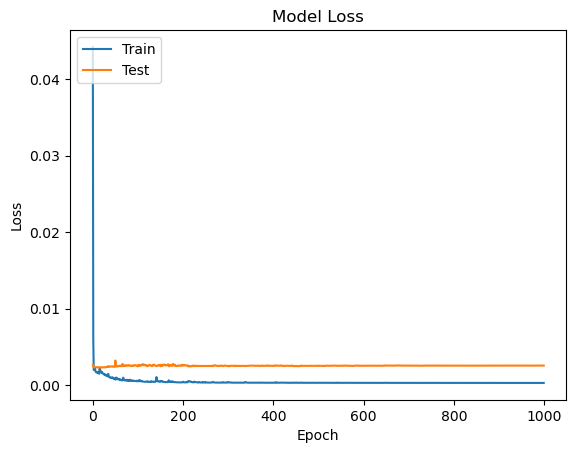

In [13]:
# Plot the loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
(1737, 32, 1)
(1737, 32, 1)


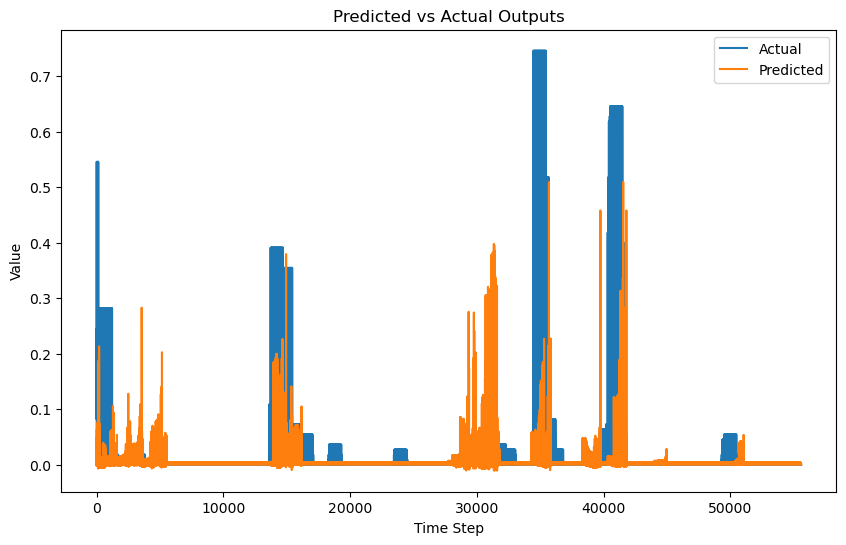

In [14]:
# Make predictions on the test set
predictions = model.predict(test_set)

# Extract the actual values from the test set
actuals = np.concatenate([y for x, y in test_set], axis=0)


print(predictions.shape)
print(actuals.shape)

# Flatten the predictions and actuals
predictions = predictions.flatten()
actuals = actuals.flatten()

# # Inverse transform the predictions and actuals
# predictions = scaler.inverse_transform(predictions.reshape(-1, 2)).flatten()
# actuals = scaler.inverse_transform(actuals.reshape(-1, 2)).flatten()

# Plot the predicted vs actual outputs
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Predicted vs Actual Outputs')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


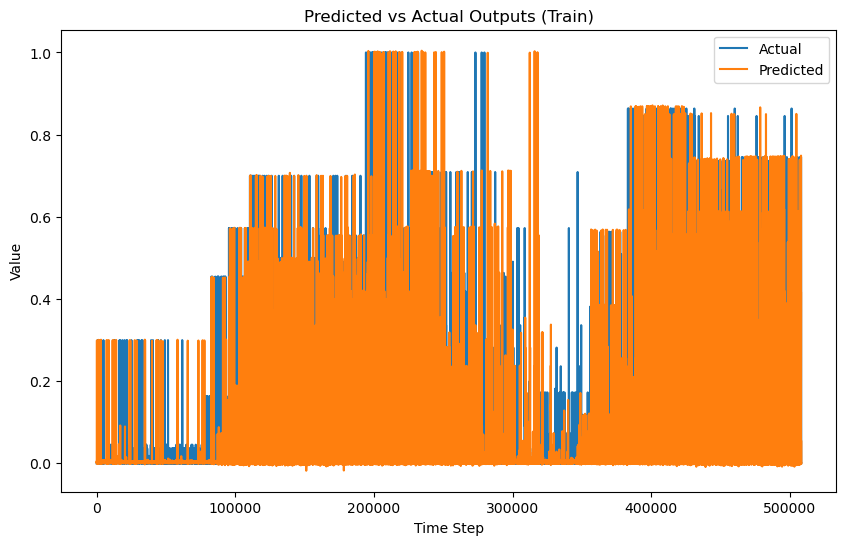

In [15]:
y_pred_train = model.predict(train_set)
y_train = np.concatenate([y for x, y in train_set], axis=0)

y_pred_train = y_pred_train.flatten()
y_train = y_train.flatten()

plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(y_pred_train, label='Predicted')
plt.title('Predicted vs Actual Outputs (Train)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [16]:
model.save_weights('corrector-ae.weights.h5')

In [17]:
# Load the 'beirut-daily-precipitation.csv' file
beirut_df = pd.read_csv('data/beirut-hourly-precipitation.csv')

# Create a windowed dataset from df['value'] without shuffling
beirut_values = beirut_df['value'].values
beirut_values = scaler.transform(beirut_values.reshape(-1, 1)).flatten()
beirut_dataset = windowed_dataset_single(beirut_values, window_size, batch_size)

# Pass the windowed dataset to the model for inference
predictions = model.predict(beirut_dataset)

# Unwrap the windows
corrected_values = predictions.flatten()

# Inverse transform the corrected values
corrected_values = scaler.inverse_transform(corrected_values.reshape(-1, 1)).flatten()

# corrected_values = scaler.inverse_transform(corrected_values.reshape(-1, 2)).flatten()
print(len(corrected_values))
print(len(beirut_df))

# Save the outputs to 'beirut-daily-corrected.csv'
beirut_df = beirut_df[:len(corrected_values)]
beirut_df['value'] = corrected_values
beirut_df.to_csv('data/beirut-daily-corrected.csv', index=False)

      1/Unknown 1s 712ms/step

2025-03-24 03:17:32.180976: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 80 bytes spill stores, 80 bytes spill loads



4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 530ms/step
25152
25166


/home/edargham/anaconda3/envs/thesis/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
